# **Implementando um Modelo GPT do Zero para Gerar Texto**

Você já aprendeu e codificou o **mecanismo de atenção multicabeça (multi-head attention mechanism)**, um dos componentes principais dos LLMs. Agora, codificaremos os outros blocos de construção de um LLM e os montaremos em um modelo semelhante ao GPT, que treinaremos no próximo capítulo para gerar texto semelhante ao humano.

A arquitetura do LLM, referenciada na figura 4.1, consiste em vários blocos de construção. Começaremos com uma visão de cima para baixo da arquitetura do modelo antes de abordar os componentes individuais com mais detalhes.

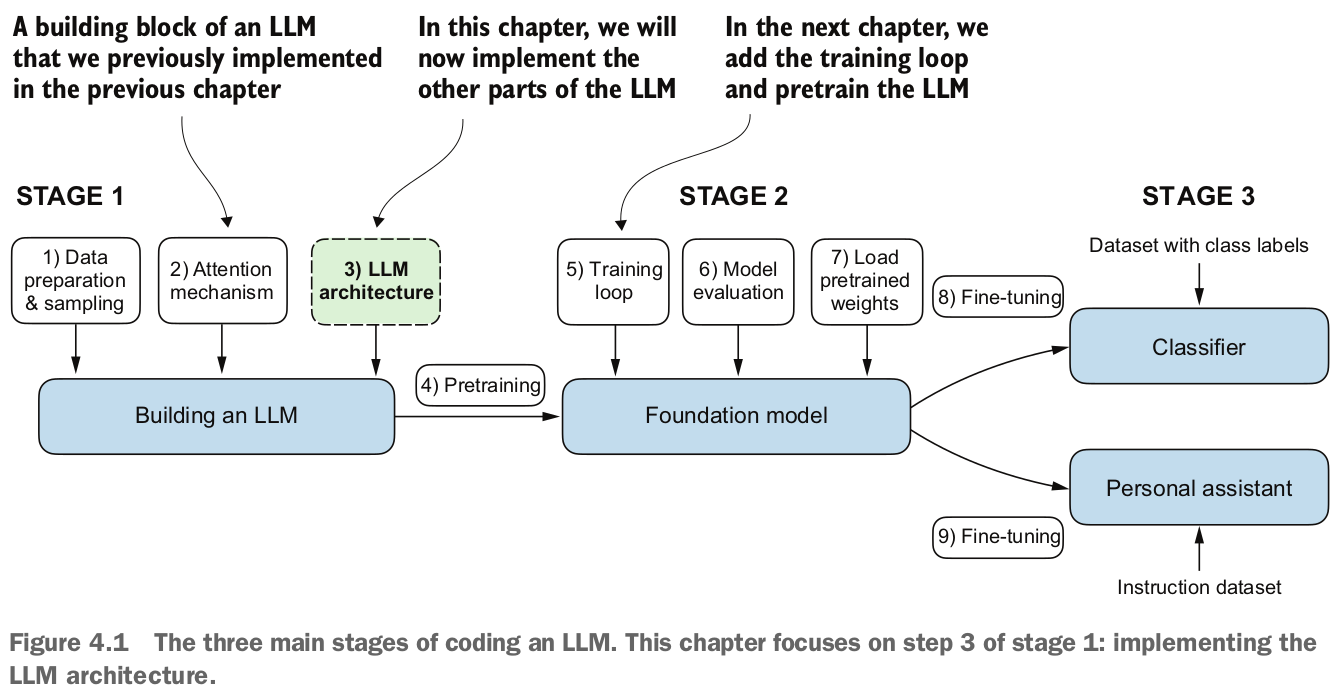

## **1 - Codificando uma Arquitetura LLM**

LLMs, como o GPT (que significa ***transformador pré-treinado generativo/generative pretrained transformer***), são grandes arquiteturas de redes neurais profundas projetadas para gerar novos textos, uma palavra (ou token) por vez. No entanto, apesar do seu tamanho, a arquitetura do modelo é menos complexa do que se imagina, visto que muitos de seus componentes são repetidos, como veremos mais adiante. A Figura 4.2 fornece uma visão de cima para baixo de um LLM semelhante ao GPT, com seus principais componentes destacados.

Já abordamos vários aspectos da arquitetura do LLM, como a tokenização e a incorporação de entradas e o módulo de atenção multicabeça mascarado. Agora,
implementaremos a estrutura central do modelo GPT, incluindo seus blocos transformadores, que posteriormente treinaremos para gerar texto semelhante ao humano.

Anteriormente, usávamos dimensões de incorporação menores para simplificar, garantindo que os conceitos e exemplos coubessem confortavelmente em uma única página. Agora, estamos ampliando para o tamanho de um pequeno modelo GPT-2, especificamente a menor versão com 124 milhões de parâmetros, conforme descrito em “Language Models Are Unsupervised Multitask Learners”, de Radford et al. (https://mng.bz/yoBq). Observe que, embora o relatório original mencione 117 milhões de parâmetros, isso foi corrigido posteriormente. No capítulo 6, nos concentraremos em carregar pesos pré-treinados em nossa implementação e adaptá-la para modelos GPT-2 maiores com 345, 762 e 1.542 milhões de parâmetros.

No contexto de aprendizado profundo e LLMs como o GPT, o termo “parâmetros” refere-se aos pesos treináveis do modelo. Esses pesos são essencialmente as variáveis internas do modelo que são ajustadas e otimizadas durante o processo de treinamento para minimizar uma função de perda específica. Essa otimização permite que o modelo aprenda com os dados de treinamento.

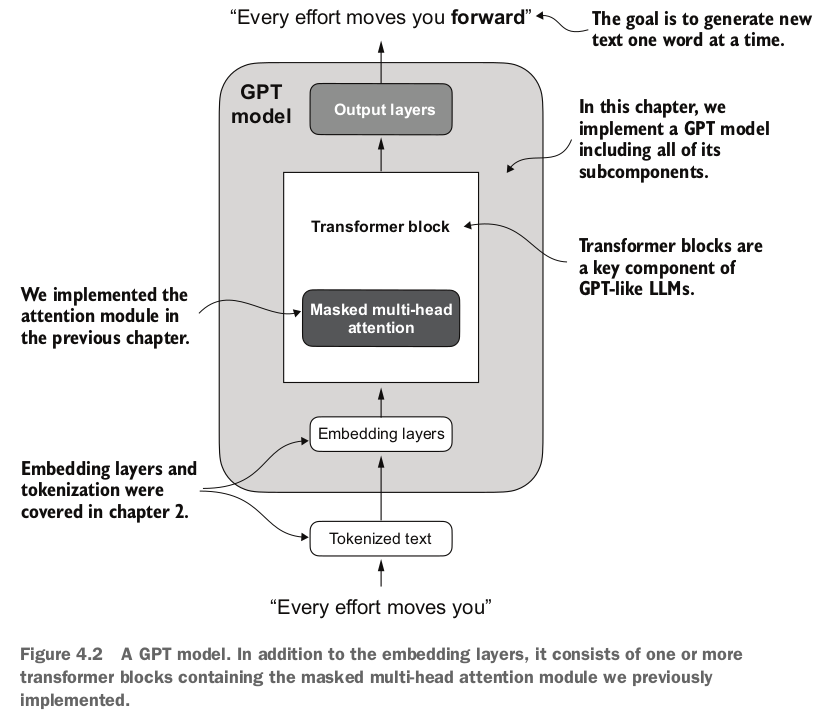

Por exemplo, em uma camada de rede neural representada por uma matriz (ou tensor) de pesos com dimensões 2.048 × 2.048, cada elemento dessa matriz é um parâmetro. Como há 2.048 linhas e 2.048 colunas, o número total de parâmetros nessa camada é 2.048 multiplicado por 2.048, o que equivale a 4.194.304 parâmetros.

---

$\large \textbf{GPT-2 vs. GPT-3}$

Observe que estamos nos concentrando no GPT-2 porque a OpenAI disponibilizou publicamente os pesos do modelo pré-treinado, que carregaremos em nossa implementação no capítulo 6. O GPT-3 é fundamentalmente o mesmo em termos de arquitetura de modelo, exceto pelo fato de ser ampliado de 1,5 bilhão de parâmetros no GPT-2 para 175 bilhões de parâmetros no GPT-3, e ser treinado com mais dados. No momento em que este artigo foi escrito, os pesos para o GPT-3 não estavam disponíveis publicamente. O GPT-2 também é uma opção melhor para aprender a implementar LLMs, pois pode ser executado em um único laptop, enquanto o GPT-3 requer um cluster de GPU para treinamento e inferência. De acordo com o Lambda Labs (https://lambdalabs.com/), levaria 355 anos para treinar o GPT-3 em uma única GPU de data center V100 e 665 anos em uma GPU RTX 8000 de consumidor.

---

Especificamos a configuração do pequeno modelo GPT-2 por meio do seguinte dicionário Python, que usaremos nos exemplos de código posteriormente:

In [ ]:
# Dicionário que define a configuração de um pequeno modelo GPT-2 (versão de 124 milhões de parâmetros)
# Esta configuração é baseada nas especificações do artigo original do GPT-2.
GPT_CONFIG_124M = {
  # vocab_size: O tamanho do vocabulário, que é o número total de tokens (palavras, subpalavras, caracteres especiais)
  # que o modelo pode entender e gerar. No caso do GPT-2, é 50257. Cada token corresponde a um índice único.
  "vocab_size": 50257,

  # context_length: O número máximo de tokens que o modelo pode considerar em uma única entrada.
  # Também conhecido como tamanho da janela de contexto. Para o GPT-2, é 1024.
  # Isso significa que o modelo pode "olhar" para os 1024 tokens anteriores ao gerar o próximo token.
  "context_length": 1024,

  # emb_dim: A dimensão do vetor de incorporação (embedding vector).
  # Cada token é representado por um vetor numérico de tamanho emb_dim.
  # Este vetor captura a informação semântica do token. Para o GPT-2, é 768.
  # Vetores de incorporação maiores podem capturar nuances mais finas de significado.
  "emb_dim": 768,

  # n_heads: O número de cabeças no mecanismo de atenção multicabeça (multi-head attention).
  # A atenção multicabeça permite que o modelo foque em diferentes partes da sequência de entrada
  # simultaneamente. Cada cabeça aprende a focar em diferentes relacionamentos entre tokens.
  # Para o GPT-2, são 12 cabeças.
  "n_heads": 12,

  # n_layers: O número de camadas do transformador no modelo.
  # O modelo GPT é composto por uma pilha de n_layers blocos de transformador.
  # Cada bloco processa a informação da camada anterior. Para o GPT-2, são 12 camadas.
  # Mais camadas permitem que o modelo capture padrões mais complexos nos dados.
  "n_layers": 12,

  # drop_rate: A taxa de dropout usada durante o treinamento.
  # Dropout é uma técnica de regularização onde um percentual de neurônios é "desligado" aleatoriamente
  # durante o treinamento para evitar overfitting. Para o GPT-2, é 0.1 (10%).
  "drop_rate": 0.1,

  # qkv_bias: Um booleano que indica se um termo de polarização (bias) é adicionado
  # às projeções Q (Query), K (Key) e V (Value) nas camadas de atenção.
  # Um bias permite que as transformações aprendam um deslocamento constante.
  # Para o GPT-2 base, não há bias (False), embora algumas implementações possam usar True.
  "qkv_bias": False
}

No dicionário `GPT_CONFIG_124M`, usamos nomes de variáveis concisos para maior clareza e para
evitar longas linhas de código:

- `vocab_size` refere-se a um vocabulário de 50.257 palavras, conforme usado pelo tokenizador BPE (consulte o capítulo 2).

- `context_length` denota o número máximo de tokens de entrada que o modelo pode manipular por meio de embeddings posicionais (consulte o capítulo 2).

- `emb_dim` representa o tamanho do embedding, transformando cada token em um vetor de 768 dimensões.

- `n_heads` indica a contagem de cabeças de atenção no mecanismo de atenção com múltiplas cabeças (consulte o capítulo 3).

- `n_layers` especifica o número de blocos transformadores no modelo, que
abordaremos na próxima discussão.

- `drop_rate` indica a intensidade do mecanismo de dropout (0,1 implica em um dropout aleatório de 10% de unidades ocultas) para evitar overfitting (ver capítulo 3).

- `qkv_bias` determina se um vetor de viés deve ser incluído nas camadas lineares da atenção multicabeça para cálculos de consulta, chave e valor. Inicialmente, desabilitaremos isso, seguindo as normas dos LLMs modernos, mas revisitaremos isso no capítulo 6, quando carregarmos pesos GPT-2 pré-treinados do OpenAI em nosso modelo (ver capítulo 6).

Usando essa configuração, implementaremos uma arquitetura de espaço reservado (Placeholder) para GPT (**Modelo-GPT Dummy/DummyGPTModel**), conforme mostrado na figura 4.3. Isso nos dará uma visão geral de como tudo se encaixa e quais outros componentes precisamos codificar para montar a arquitetura completa do modelo GPT.

Os quadros numerados na figura 4.3 ilustram a ordem em que abordamos os conceitos individuais necessários para codificar a arquitetura GPT final. Começaremos com a etapa 1, um backbone GPT (backbone pode ser visto como um intermediário na transmissão de mensagens e dados entre redes locais) de espaço reservado que chamaremos de **Modelo-GPT Dummy (DummyGPTModel)**.

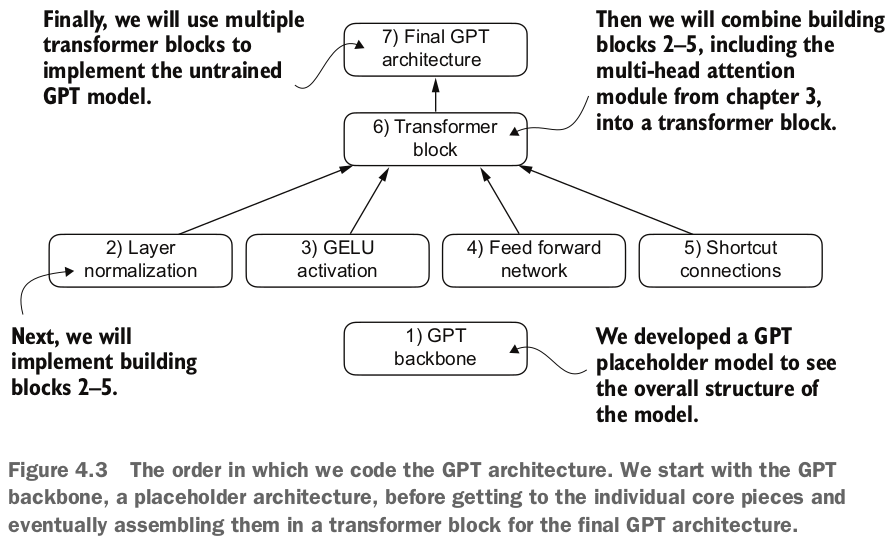

In [ ]:
import torch # Importa a biblioteca principal do PyTorch
import torch.nn as nn # Importa o módulo de redes neurais do PyTorch

In [ ]:
# Define a classe DummyGPTModel que herda de nn.Module (classe base para todos os módulos de redes neurais no PyTorch)
class DummyGPTModel(nn.Module):

    # Método construtor da classe
    def __init__(self, cfg):
        # Inicializa a classe pai (nn.Module)
        super().__init__()
        # Define a camada de embedding para os tokens.
        # nn.Embedding é uma tabela de lookup que armazena embeddings fixos de um dicionário de tamanhos.
        # cfg["vocab_size"]: Tamanho do vocabulário (número de tokens únicos).
        # cfg["emb_dim"]: Dimensão do vetor de embedding para cada token.
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # Define a camada de embedding para as posições.
        # Permite que o modelo leve em conta a ordem dos tokens na sequência.
        # cfg["context_length"]: Comprimento máximo da sequência que o modelo pode processar.
        # cfg["emb_dim"]: Dimensão do vetor de embedding para cada posição.
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # Define a camada de Dropout para os embeddings.
        # Ajuda a prevenir overfitting zerando aleatoriamente uma fração dos elementos de entrada durante o treinamento.
        # cfg["drop_rate"]: A probabilidade de um elemento ser zerado.
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # Define uma sequência de blocos do Transformer.
        # nn.Sequential executa seus módulos em ordem.
        # DummyTransformerBlock é um placeholder que será implementado posteriormente.
        # A lista de blocos é criada usando uma comprehension de lista para o número de camadas definido em cfg["n_layers"].
        self.trf_blocks = nn.Sequential(
            # O '*' aqui é o operador de desempacotamento (unpacking operator) do Python.
            # Ele "desempacota" a lista gerada pela comprehension de lista,
            # passando cada item da lista como um argumento separado para nn.Sequential.
            # Por exemplo, se cfg["n_layers"] fosse 3, a comprehension de lista criaria:
            # [DummyTransformerBlock(cfg), DummyTransformerBlock(cfg), DummyTransformerBlock(cfg)]
            # O '*' transforma isso em argumentos separados, como se você tivesse escrito:
            # nn.Sequential(DummyTransformerBlock(cfg), DummyTransformerBlock(cfg), DummyTransformerBlock(cfg))
            # Isso é necessário porque nn.Sequential espera os módulos como argumentos individuais, não como uma única lista.
            *[DummyTransformerBlock(cfg) # Esta é uma comprehension de lista. Ela cria uma lista de módulos DummyTransformerBlock.
                                         # DummyTransformerBlock é um placeholder que representa um bloco de processamento Transformer completo.
                                         # Ele inclui atenção, feed-forward, normalização e atalhos, que serão implementados em detalhes posteriormente.
              for _ in range(cfg["n_layers"])] # Itera 'n_layers' vezes. Em cada iteração, uma nova instância de DummyTransformerBlock(cfg) é criada e adicionada à lista.
        )
        # Define a camada de normalização final.
        # DummyLayerNorm é um placeholder que será implementado posteriormente.
        # Aplica normalização na última camada do Transformer.
        # cfg["emb_dim"]: A dimensão sobre a qual a normalização é aplicada.
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # Define a camada linear de saída (cabeça de classificação).
        # Mapeia o vetor de características finais para as probabilidades de cada token no vocabulário.
        # cfg["emb_dim"]: Dimensão de entrada (dimensão do embedding).
        # cfg["vocab_size"]: Dimensão de saída (tamanho do vocabulário).
        # bias=False: Indica que não será adicionado um termo de polarização a esta camada linear.
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    # Método forward define a passagem para frente do modelo
    # in_idx: Tensor de entrada contendo os índices dos tokens (batch_size, seq_len)
    def forward(self, in_idx):
        # Obtém o tamanho do batch e o comprimento da sequência a partir do tensor de entrada
        batch_size, seq_len = in_idx.shape

        # Obtém os embeddings dos tokens de entrada.
        # self.tok_emb é a camada nn.Embedding definida no construtor (__init__).
        # in_idx: Tensor de entrada contendo os índices (IDs) dos tokens para este lote.
        #         Sua forma é (batch_size, seq_len).
        # self.tok_emb(in_idx): Ao "chamar" a camada de embedding com o tensor de índices,
        #                       o PyTorch realiza uma busca na tabela de embeddings (self.tok_emb.weight).
        #                       Para cada índice em in_idx, ele encontra o vetor de embedding correspondente.
        # tok_embeds: O tensor resultante dos embeddings de token.
        #             Sua forma será (batch_size, seq_len, emb_dim).
        #             Exemplo: Se batch_size=2, seq_len=4 e emb_dim=768, tok_embeds terá forma (2, 4, 768).
        #             Cada linha (exemplo no lote) e cada posição (token na sequência) agora tem um vetor de 768 dimensões.
        tok_embeds = self.tok_emb(in_idx)

        # Obtém os embeddings posicionais para a sequência atual.
        # Os embeddings posicionais fornecem informação sobre a posição de cada token na sequência,
        # o que é crucial para modelos Transformer, pois eles não processam sequências sequencialmente por padrão.
        # torch.arange(seq_len, device=in_idx.device):
        #   - torch.arange(seq_len): Cria um tensor 1D contendo inteiros sequenciais começando de 0 até (seq_len - 1).
        #                           Exemplo: Se seq_len for 4, isso criará o tensor [0, 1, 2, 3].
        #                           Este tensor representa os índices de posição para a sequência atual.
        #   - device=in_idx.device: Garante que este tensor de índices de posição seja criado no MESMO dispositivo
        #                           (CPU ou GPU) onde o tensor de entrada 'in_idx' está localizado.
        #                           Isso é essencial para evitar erros ao realizar operações (como adição)
        #                           entre tensores que estão em dispositivos diferentes.
        # self.pos_emb(...):
        #   - self.pos_emb é a camada nn.Embedding definida no construtor (__init__) para os embeddings posicionais.
        #     Ela foi inicializada com cfg["context_length"] (tamanho máximo do contexto) como o tamanho do vocabulário de posições,
        #     e cfg["emb_dim"] como a dimensão do embedding posicional.
        #   - Ao passar o tensor de índices de posição (criado com torch.arange) para esta camada de embedding,
        #     ela busca os vetores de embedding correspondentes para cada posição.
        # pos_embeds: O tensor resultante dos embeddings posicionais para a sequência atual.
        #             Sua forma será (seq_len, emb_dim).
        #             Exemplo: Se seq_len=4 e emb_dim=768, pos_embeds terá forma (4, 768).
        #             Cada linha (posição na sequência) agora tem um vetor de 768 dimensões.
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        # Neste ponto, temos:
        # - tok_embeds: forma (batch_size, seq_len, emb_dim) - embeddings baseados no conteúdo dos tokens.
        # - pos_embeds: forma (seq_len, emb_dim) - embeddings baseados na posição dos tokens.

        # ----------

        # Combina os embeddings de token e posicionais (soma).
        # O PyTorch usa "broadcasting" aqui. Como pos_embeds tem forma (seq_len, emb_dim) e tok_embeds tem forma (batch_size, seq_len, emb_dim),
        # o pos_embeds é automaticamente "esticado" ou copiado ao longo da primeira dimensão (batch_size)
        # para corresponder à forma de tok_embeds antes da adição.
        # Isso permite que o embedding posicional correto seja adicionado ao embedding de token correspondente
        # para cada token em cada sequência no lote.
        # x: O tensor resultante da soma dos embeddings de token e posicionais.
        #    Sua forma é (batch_size, seq_len, emb_dim).
        x = tok_embeds + pos_embeds

        # Aplica dropout aos embeddings combinados.
        # self.drop_emb é a camada nn.Dropout definida no construtor.
        # x: O tensor de embeddings combinados.
        # self.drop_emb(x): Durante o treinamento, alguns elementos em 'x' serão definidos como zero aleatoriamente
        #                   com base na taxa de dropout (cfg["drop_rate"]). Durante a avaliação, esta camada não faz nada.
        # x: O tensor resultante após a aplicação do dropout (ou sem alteração se em modo de avaliação).
        x = self.drop_emb(x)

        # Passa a saída pelos blocos do Transformer.
        # self.trf_blocks é o nn.Sequential contendo a pilha de DummyTransformerBlocks.
        # x: O tensor de embeddings combinados e com dropout.
        # self.trf_blocks(x): Passa 'x' sequencialmente por cada bloco DummyTransformerBlock.
        #                    Como DummyTransformerBlock é um placeholder que apenas retorna a entrada,
        #                    neste DummyGPTModel, este passo não altera 'x'.
        # x: O tensor resultante após passar pelos blocos Transformer. Sua forma é (batch_size, seq_len, emb_dim).
        x = self.trf_blocks(x)

        # Aplica normalização na saída dos blocos do Transformer.
        # self.final_norm é a instância de DummyLayerNorm definida no construtor.
        # x: O tensor resultante dos blocos Transformer.
        # self.final_norm(x): Passa 'x' pela camada de normalização final.
        #                    Como DummyLayerNorm é um placeholder que apenas retorna a entrada,
        #                    neste DummyGPTModel, este passo não altera 'x'.
        # x: O tensor resultante após a normalização final (sem alteração neste dummy).
        x = self.final_norm(x)

        # Passa a saída normalizada pela camada linear final para obter os logits.
        # self.out_head é a camada nn.Linear definida no construtor.
        # x: O tensor resultante após a normalização final.
        # self.out_head(x): Passa 'x' pela camada linear. Realiza uma transformação linear: output = input * Weight.
        #                  Mapeia a dimensão emb_dim para vocab_size.
        # logits: O tensor resultante dos logits.
        #         Sua forma será (batch_size, seq_len, vocab_size).
        #         Cada valor em logits[b, s, v] representa a pontuação para o token com ID 'v'
        #         sendo o próximo token após a posição 's' na amostra 'b'.
        logits = self.out_head(x)

        # Retorna os logits, que são as pontuações brutas de previsão do modelo.
        return logits

In [ ]:
# Define a classe DummyTransformerBlock que herda de nn.Module.
# nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
# Herdar de nn.Module fornece funcionalidades essenciais como rastreamento de parâmetros, gerenciamento de sub-módulos, etc.
class DummyTransformerBlock(nn.Module):

    # Método construtor da classe.
    # Este método é chamado quando você cria uma instância da classe (ex: block = DummyTransformerBlock(config)).
    # cfg: Um dicionário (ou objeto) contendo a configuração do modelo (ex: GPT_CONFIG_124M).
    # Embora cfg seja passado, neste bloco dummy ele não é usado para definir a arquitetura interna.
    def __init__(self, cfg):
        # Chama o construtor da classe pai (nn.Module).
        # Isso é essencial para que o PyTorch inicialize corretamente o módulo.
        # Ele configura coisas como o registro de parâmetros e sub-módulos.
        super().__init__()
        # Este é um bloco "dummy" (fictício) ou placeholder.
        # Na implementação real de um Transformer Block, o construtor __init__
        # criaria as camadas internas do bloco, como camadas de atenção (self-attention)
        # e redes feed-forward, usando a configuração 'cfg'.
        # Por exemplo:
        # self.attention = MultiHeadAttention(cfg) # Módulo de atenção real
        # self.feed_forward = FeedForward(cfg) # Módulo feed-forward real
        # self.norm1 = LayerNorm(cfg["emb_dim"]) # Camada de normalização 1
        # self.norm2 = LayerNorm(cfg["emb_dim"]) # Camada de normalização 2


    # Método forward define a passagem para frente do módulo.
    # Este método é chamado quando você "chama" a instância do módulo com um tensor de entrada (ex: output = block(input_tensor)).
    # x: O tensor de entrada para este bloco.
    # Em um modelo Transformer, 'x' seria a saída da camada anterior (ou os embeddings iniciais).
    # A forma típica de 'x' seria (batch_size, seq_len, emb_dim).
    def forward(self, x):
        # Este bloco dummy simplesmente retorna o tensor de entrada sem fazer nenhuma transformação.
        # Isso significa que ele não tem nenhum efeito computacional no tensor 'x'.
        # Em um Transformer Block real, o método forward implementaria a lógica do bloco,
        # que geralmente envolve a aplicação de:
        # 1. Normalização da camada (LayerNorm)
        # 2. Mecanismo de atenção (Self-Attention) - possivelmente com dropout e adição residual
        # 3. Normalização da camada (LayerNorm)
        # 4. Rede feed-forward - possivelmente com dropout e adição residual
        # A lógica completa seria algo como:
        # residual = x
        # x = self.norm1(x)
        # x = self.attention(x)
        # x = residual + x # Adição residual
        # residual = x
        # x = self.norm2(x)
        # x = self.feed_forward(x)
        # x = residual + x # Adição residual
        # return x # Retorna o tensor processado pelo bloco

        # No entanto, neste caso dummy, para fins de ilustração e estruturação inicial,
        # simplesmente passamos a entrada diretamente para a saída.
        return x

In [ ]:
# Define a classe DummyLayerNorm que herda de nn.Module.
# nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
# Herdar dela permite que o PyTorch gerencie esta classe como parte de uma rede neural,
# incluindo o rastreamento de parâmetros (se houvesse), o movimento para diferentes dispositivos (CPU/GPU), etc.
class DummyLayerNorm(nn.Module):

    # Método construtor da classe.
    # Este método é chamado quando você cria uma instância da classe (ex: layer_norm = DummyLayerNorm(768)).
    # normalized_shape: Geralmente, este parâmetro especifica a forma (dimensões) dos dados que serão normalizados.
    #                   Em Layer Normalization, normalmente é a dimensão da característica (embedding dimension).
    #                   Por exemplo, para um tensor de forma (batch_size, seq_len, emb_dim), normalized_shape seria emb_dim.
    #                   Neste dummy, o valor passado para normalized_shape não é usado na lógica, mas a assinatura
    #                   do método é mantida para ser compatível com a implementação real da LayerNorm.
    # eps: Um pequeno valor epsilon adicionado ao denominador durante a normalização para evitar divisão por zero.
    #      O valor padrão de 1e-5 é uma escolha comum para estabilidade numérica.
    #      Neste dummy, o valor de eps também não é usado, pois não há cálculo de normalização.
    def __init__(self, normalized_shape, eps=1e-5):
        # Chama o construtor da classe pai (nn.Module).
        # Isso é crucial para a inicialização correta do módulo PyTorch.
        super().__init__()
        # Em uma implementação real de LayerNorm, o construtor __init__
        # inicializaria os parâmetros aprendíveis 'weight' e 'bias' (ganho e deslocamento)
        # e talvez armazenaria 'normalized_shape' e 'eps'.
        # Exemplo de uma LayerNorm real:
        # self.normalized_shape = normalized_shape
        # self.eps = eps
        # self.weight = nn.Parameter(torch.ones(normalized_shape)) # Parâmetro aprendível de ganho
        # self.bias = nn.Parameter(torch.zeros(normalized_shape)) # Parâmetro aprendível de bias


    # Método forward define a passagem para frente do módulo.
    # Este método é chamado quando você "chama" a instância do módulo com um tensor de entrada (ex: output = layer_norm(input_tensor)).
    # x: O tensor de entrada para esta camada de normalização.
    #    Em um modelo Transformer, 'x' seria a saída de uma camada anterior (ex: após a atenção ou a feed-forward).
    #    A forma típica de 'x' seria (batch_size, seq_len, emb_dim).
    def forward(self, x):
        # Este bloco dummy simplesmente retorna o tensor de entrada 'x' sem fazer nenhuma transformação ou normalização.
        # Isso significa que ele não realiza a operação de Layer Normalization.
        # Em uma implementação real de LayerNorm, o método forward calcularia a média e o desvio padrão
        # ao longo da(s) dimensão(ões) especificada(s) por 'normalized_shape', e então aplicaria a fórmula de normalização:
        # normalized_x = (x - mean) / sqrt(variance + eps)
        # E opcionalmente aplicaria os parâmetros aprendíveis 'weight' e 'bias':
        # output = self.weight * normalized_x + self.bias
        # A lógica completa seria algo como:
        # mean = x.mean(dim=-1, keepdim=True) # Calcula a média na última dimensão
        # var = x.var(dim=-1, keepdim=True, unbiased=False) # Calcula a variância na última dimensão
        # x_normalized = (x - mean) / torch.sqrt(var + self.eps) # Aplica a normalização
        # return self.weight * x_normalized + self.bias # Aplica ganho e bias (se existirem)

        # No entanto, neste caso dummy, apenas passamos a entrada diretamente para a saída
        # para servir como um placeholder na arquitetura geral do modelo.
        return x

A classe `DummyGPTModel` neste código define uma versão simplificada de um modelo semelhante ao GPT usando o módulo de rede neural do PyTorch (`nn.Module`). A arquitetura do modelo na classe `DummyGPTModel` consiste em embeddings posicionais e de token, dropout, uma série de blocos transformadores (`DummyTransformerBlock`), uma normalização de camada final (`DummyLayerNorm`) e uma camada de saída linear (`out_head`). A configuração é passada por meio de um dicionário Python, por exemplo, o dicionário `GPT_CONFIG_124M` que criamos anteriormente.

O método `forward` descreve o fluxo de dados através do modelo: ele calcula os embeddings posicionais e de token para os índices de entrada, aplica o dropout, processa os dados através dos blocos transformadores, aplica a normalização e, finalmente, produz logits com a camada de saída linear.

O código da Listagem 4.1 já está funcional. No entanto, por enquanto, observe que usamos marcadores de posição (`DummyLayerNorm` e `DummyTransformerBlock`) para o bloco transformador e a normalização de camadas, que desenvolveremos posteriormente.

Em seguida, prepararemos os dados de entrada e inicializaremos um novo modelo GPT para ilustrar seu uso. Com base em nossa codificação do tokenizador (consulte o Capítulo 2), vamos agora considerar uma visão geral de alto nível de como os dados entram e saem de um modelo GPT, conforme mostrado na
Figura 4.4.

Para implementar essas etapas, tokenizamos um lote composto por duas entradas de texto para o modelo GPT usando o tokenizador tiktoken do Capítulo 2:

In [ ]:
import tiktoken # Importa a biblioteca tiktoken, desenvolvida pela OpenAI, usada para tokenização eficiente, especialmente para modelos GPT.

tokenizer = tiktoken.get_encoding("gpt2") # Inicializa um objeto tokenizer específico para o modelo GPT-2.
                                          # "gpt2" especifica o esquema de codificação de tokens (BPE - Byte Pair Encoding) usado pelo GPT-2.
                                          # Este objeto tokenizer será usado para converter texto em sequências de inteiros (tokens) e vice-versa.

batch = [] # Cria uma lista vazia chamada 'batch'. Esta lista será usada para armazenar as sequências de tokens (como tensores PyTorch)
           # para cada frase de entrada antes de serem combinadas em um único tensor de lote.

txt1 = "Every effort moves you" # Define a primeira string de texto de entrada.
txt2 = "Every day holds a"     # Define a segunda string de texto de entrada.
                                # Estas são as frases que queremos processar com o modelo.

batch.append(torch.tensor(tokenizer.encode(txt1))) # Tokeniza a primeira string (txt1) usando o tokenizer.encode().
                                                  # tokenizer.encode(txt1) converte a string em uma lista de inteiros (IDs de token).
                                                  # torch.tensor() converte essa lista de inteiros em um tensor PyTorch.
                                                  # batch.append() adiciona este tensor à lista 'batch'.

batch.append(torch.tensor(tokenizer.encode(txt2))) # Tokeniza a segunda string (txt2) e a converte em um tensor PyTorch,
                                                  # adicionando-o à lista 'batch', de forma semelhante à linha anterior.
                                                  # Agora, a lista 'batch' contém dois tensores, cada um representando uma frase tokenizada.

batch = torch.stack(batch, dim=0) # Combina os tensores na lista 'batch' em um único tensor grande.
                                  # torch.stack empilha os tensores ao longo de uma nova dimensão.
                                  # dim=0 especifica que a nova dimensão será a primeira (dimensão do lote).
                                  # O resultado é um tensor de forma (número_de_frases, comprimento_máximo_da_frase_tokenizada).
                                  # Este formato (batch_size, seq_len) é o esperado pela maioria dos modelos de linguagem como entrada.

print(batch) # Imprime o tensor de lote resultante.
             # A saída mostrará um tensor PyTorch contendo os IDs de token para as duas frases empilhadas.
             # Isso demonstra a conversão do texto de entrada em um formato numérico que o modelo GPT pode processar.

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


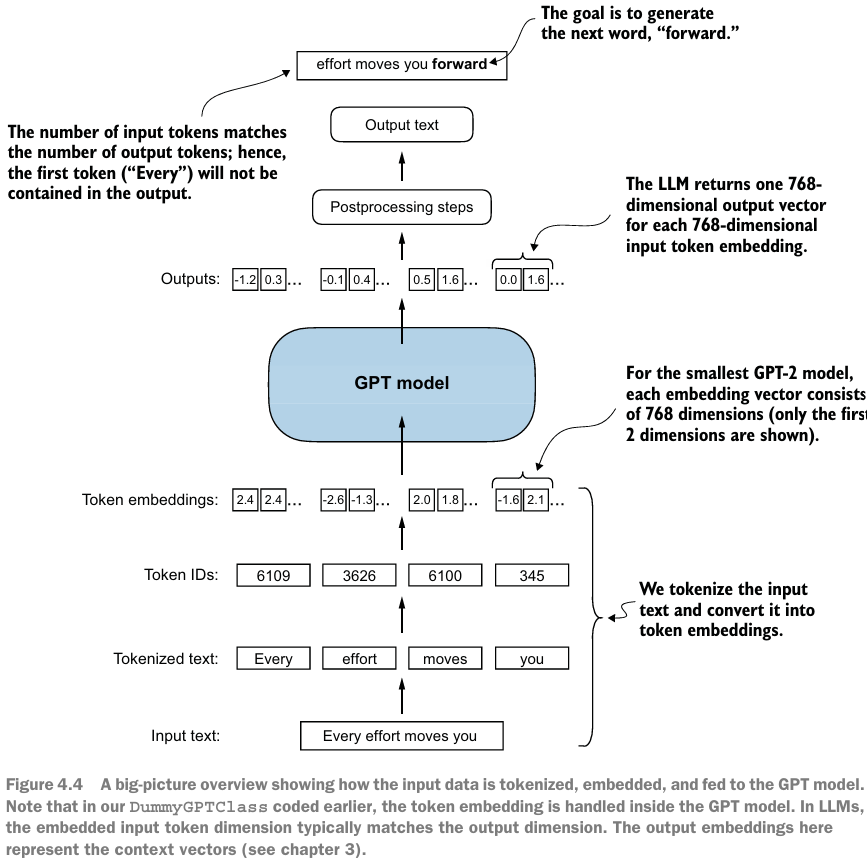

Em seguida, inicializamos uma nova instância `DummyGPTModel` de 124 milhões de parâmetros e a alimentamos com o `batch` tokenizado. As saídas do modelo, comumente chamadas de logits, são as seguintes:

In [ ]:
torch.manual_seed(123) # Define a semente para o gerador de números aleatórios do PyTorch.
                       # Isso garante que a inicialização dos pesos do modelo seja a mesma toda vez que o código for executado,
                       # tornando os resultados reproduzíveis. É útil para depuração e comparação de experimentos.


model = DummyGPTModel(GPT_CONFIG_124M) # Cria uma instância do modelo DummyGPTModel.
                                       # DummyGPTModel é a classe Python que definimos anteriormente, representando a arquitetura básica do GPT.
                                       # GPT_CONFIG_124M é o dicionário que contém os hiperparâmetros do modelo (tamanho do vocabulário, dimensão do embedding, etc.).
                                       # Ao passar este dicionário para o construtor (__init__), o modelo é configurado com base nessas especificações.


logits = model(batch) # Realiza a passagem para frente (forward pass) dos dados de entrada através do modelo.
                      # Isso é feito chamando a instância do modelo como uma função e passando o tensor 'batch' como argumento.
                      # Internamente, o PyTorch chama o método .forward(batch) da classe DummyGPTModel.
                      # O tensor 'batch' contém os IDs dos tokens de entrada.
                      # O modelo processa esses tokens através de suas camadas (neste caso, camadas dummy) e retorna os 'logits'.
                      # Logits são as pontuações de saída bruta do modelo antes da aplicação de uma função de ativação como softmax.
                      # A forma do tensor 'logits' será (batch_size, seq_len, vocab_size), onde:
                      # - batch_size é o número de sequências no lote (neste caso, 2).
                      # - seq_len é o comprimento da sequência de entrada (neste caso, o comprimento máximo das frases tokenizadas).
                      # - vocab_size é o tamanho do vocabulário (neste caso, 50257).
                      # Cada valor em 'logits' representa a pontuação de probabilidade (não normalizada) para cada token no vocabulário
                      # em cada posição da sequência para cada amostra no lote.


print("Output shape:", logits.shape) # Imprime a forma (shape) do tensor 'logits'.
                                     # Isso nos mostra as dimensões da saída do modelo: (batch_size, seq_len, vocab_size).
                                     # Interpretação: Para cada sequência no lote e para cada posição de token nessa sequência,
                                     # temos um vetor de tamanho vocab_size, onde cada elemento corresponde a uma pontuação
                                     # para um token potencial para ser o próximo token nessa posição.


print(logits) # Imprime o conteúdo do tensor 'logits'.
              # Isso mostra os valores numéricos reais calculados pelo modelo.
              # Como este é um modelo "dummy" sem treinamento, esses valores são apenas resultados da inicialização aleatória
              # e das operações de identidade das camadas dummy. Em um modelo treinado, esses valores refletiriam as
              # probabilidades aprendidas para a geração do próximo token.
              # Interpretação: Estes são os scores brutos que o modelo atribui a cada token possível no vocabulário
              # para cada posição de token nas sequências de entrada. Valores mais altos indicam que o modelo
              # considera aquele token mais provável de ocorrer naquela posição.

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


O tensor de saída possui duas linhas correspondentes às duas amostras de texto. Cada amostra de texto consiste em quatro tokens; cada token é um vetor de 50.257 dimensões, que corresponde ao tamanho do vocabulário do tokenizador.

A incorporação possui 50.257 dimensões porque cada uma dessas dimensões se refere a um token exclusivo no vocabulário. Quando implementarmos o código de pós-processamento, converteremos esses vetores de 50.257 dimensões novamente em IDs de token, que podemos então decodificar em palavras.

Agora que analisamos de cima para baixo a arquitetura do GPT e suas entradas e saídas, codificaremos os marcadores de posição individuais, começando com a classe de normalização da camada real que substituirá `DummyLayerNorm` no código anterior.

## **2 - Normalizando Ativações com Normalização de Camadas**

O treinamento de redes neurais profundas com muitas camadas pode, às vezes, ser desafiador devido a problemas como gradientes que desaparecem ou explodem. Esses problemas levam a uma dinâmica de treinamento instável e dificultam o ajuste eficaz dos pesos pela rede, o que significa que o processo de aprendizado tem dificuldade em encontrar um conjunto de parâmetros (pesos) para a rede neural que minimize a função de perda. Em outras palavras, a rede tem dificuldade em aprender os padrões subjacentes nos dados a um grau que lhe permita fazer previsões ou decisões precisas.

---

**Nota:** Se você é novo no treinamento de redes neurais e nos conceitos de gradientes, uma breve introdução a esses conceitos pode ser encontrada na seção A.4 do apêndice A. No entanto, não é necessário um profundo conhecimento matemático de gradientes para acompanhar o conteúdo deste livro.

---

Vamos agora implementar a ***normalização de camadas*** para melhorar a estabilidade e a eficiência do treinamento de redes neurais. A ideia principal por trás da normalização de camadas é ajustar as ativações (saídas) de uma camada de rede neural para que tenham uma média de 0 e uma variância de 1, também conhecida como variância unitária. Esse ajuste acelera a convergência para pesos efetivos e garante um treinamento consistente e confiável. Em arquiteturas GPT-2 e de transformadores modernos, a normalização de camadas é normalmente aplicada antes e depois do módulo de atenção multi-cabeça e, como vimos com o marcador de posição **DummyLayerNorm**, antes da camada de saída final. A Figura 4.5 fornece uma visão geral de como a normalização de camadas funciona.

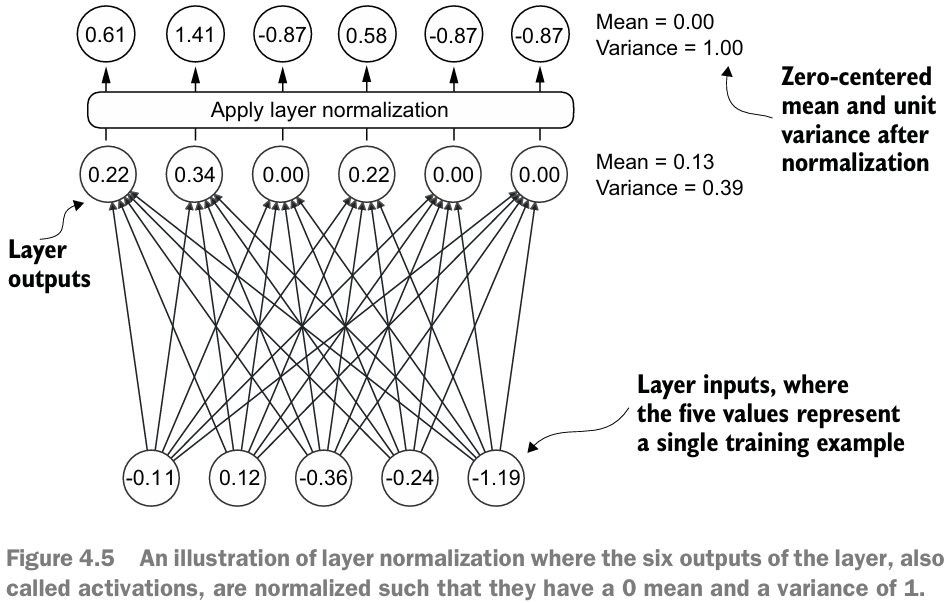

Podemos recriar o exemplo mostrado na figura 4.5 por meio do código a seguir, onde implementamos uma camada de rede neural com cinco entradas e seis saídas que aplicamos a dois exemplos de entrada. Isso imprime o seguinte tensor, onde a primeira linha lista as saídas da camada para a primeira entrada e a segunda linha lista as saídas da camada para a segunda linha:

In [ ]:
torch.manual_seed(123) # Define a semente para o gerador de números aleatórios do PyTorch.
                       # Isso garante que a geração de números aleatórios (como a inicialização dos pesos da camada Linear)
                       # seja a mesma toda vez que o código for executado. Isso é crucial para a reprodutibilidade
                       # de experimentos e para depuração. O número '123' é apenas um exemplo de semente.

batch_example = torch.randn(2, 5) # Cria um tensor PyTorch chamado 'batch_example'.
                                  # torch.randn() gera um tensor com números aleatórios amostrados de uma distribuição normal (média 0, variância 1).
                                  # O argumento (2, 5) define a forma do tensor:
                                  # - 2: Representa o tamanho do lote (batch size). Neste caso, temos 2 exemplos de dados.
                                  # - 5: Representa o número de características ou a dimensão de cada exemplo. Cada um dos 2 exemplos tem 5 valores.
                                  # Interpretação: Este tensor simula um pequeno lote de dados de entrada para uma rede neural,
                                  # onde temos 2 amostras, cada uma com 5 características.

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) # Define uma pequena rede neural sequencial, que é uma forma simples de construir modelos
                                                  # empilhando camadas em ordem.
                                                  # nn.Sequential: Contêiner para módulos que serão passados em ordem.
                                                  # nn.Linear(5, 6): Define uma camada linear (ou densa).
                                                  #   - 5: É o número de características de entrada para esta camada (deve corresponder à última dimensão do input, que é 5 em 'batch_example').
                                                  #   - 6: É o número de características de saída desta camada (o número de neurônios nesta camada).
                                                  #   Esta camada realiza uma transformação linear: output = input * Weight + Bias.
                                                  # nn.ReLU(): Define uma camada de ativação ReLU (Rectified Linear Unit).
                                                  #   Esta é uma função de ativação não linear que aplica max(0, x) elemento a elemento.
                                                  #   Ela introduz não linearidade na rede, permitindo que ela aprenda padrões mais complexos.
                                                  # Interpretação: Esta linha cria um "módulo" que pega um tensor de forma (..., 5) e o transforma
                                                  # primeiro através de uma camada linear para (..., 6) e depois aplica a função ReLU elemento a elemento
                                                  # à saída da camada linear.

out = layer(batch_example) # Passa o tensor 'batch_example' pela rede neural definida em 'layer'.
                           # Chamar uma instância de nn.Module (como 'layer') executa seu método .forward().
                           # Neste caso, o PyTorch passará 'batch_example' primeiro para nn.Linear(5, 6) e depois a saída
                           # dessa camada para nn.ReLU().
                           # Interpretação: Esta linha executa a inferência ou a passagem para frente dos dados de entrada
                           # através da nossa pequena rede neural. O resultado é armazenado na variável 'out'.
                           # A forma esperada de 'out' será a mesma do input na dimensão do lote (2),
                           # mas a última dimensão será o número de saídas da camada Linear (6),
                           # então a forma será (2, 6).

print(out) # Imprime o tensor resultante 'out'.
           # Este tensor contém as saídas da rede neural para cada exemplo no lote após a aplicação da camada linear e da ativação ReLU.
           # Interpretação: Você verá um tensor 2x6. Cada linha corresponde a um dos exemplos de entrada originais,
           # e cada coluna corresponde a uma das 6 saídas da camada linear após a ativação ReLU.
           # Os valores serão não negativos devido à função ReLU (max(0, x)).

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


A camada de rede neural que codificamos consiste em uma camada "Linear" seguida por uma função de ativação não linear, "ReLU" (abreviação de unidade linear retificada), que é uma função de ativação padrão em redes neurais. Se você não conhece "ReLU", ela simplesmente limita as entradas negativas a 0, garantindo que uma camada produza apenas valores positivos, o que explica por que a saída da camada resultante não contém valores negativos. Posteriormente, usaremos outra função de ativação mais sofisticada no GPT. Antes de aplicar a normalização de camadas a essas saídas, vamos examinar a média e a variância:

In [ ]:
 # Calcula a média dos elementos no tensor 'out'.
 # out: O tensor de entrada, que neste caso é a saída da camada linear seguida pela ReLU.
 #      Sua forma é (batch_size, seq_len) ou (batch_size, num_features_out), que é (2, 6) neste exemplo.
 # .mean(): Método para calcular a média de um tensor.
 # dim=-1: Especifica a dimensão ao longo da qual a média será calculada.
 #         -1 se refere à última dimensão do tensor. Neste caso, a última dimensão tem tamanho 6,
 #         correspondendo às saídas de cada neurônio para cada exemplo no lote.
 #         Calcular a média ao longo desta dimensão significa que teremos uma média para cada exemplo no lote.
 # keepdim=True: Garante que a dimensão ao longo da qual a média foi calculada seja mantida no tensor de saída,
 #               mas com tamanho 1. Se fosse False, a dimensão seria removida.
 #               Com keepdim=True, a forma do tensor 'mean' será (2, 1), onde 2 é o batch size e 1 é a dimensão mantida.
 #               Isso é útil para operações futuras que podem precisar que as dimensões sejam compatíveis (broadcasting).
 mean = out.mean(dim=-1, keepdim=True)

 # Calcula a variância dos elementos no tensor 'out'.
 # out: O mesmo tensor de entrada usado para a média.
 # .var(): Método para calcular a variância de um tensor.
 # dim=-1: Especifica a dimensão ao longo da qual a variância será calculada (a última dimensão, tamanho 6).
 #         Assim como na média, a variância é calculada para cada exemplo no lote.
 # keepdim=True: Mantém a dimensão calculada com tamanho 1, resultando em uma forma (2, 1) para o tensor 'var'.
 #               (Por padrão, torch.var usa o estimador não viesado (unbiased) com n-1 no denominador.
 #                Para o estimador viesado (biased) com n, você usaria unbiased=False).
 var = out.var(dim=-1, keepdim=True)

 # Imprime o rótulo "Mean:" seguido por uma nova linha.
 print("Mean:\n", mean)
 # Imprime o tensor 'mean'.
 # Interpretação: Você verá um tensor 2x1. Cada valor representa a média das 6 saídas para a linha correspondente
 #                no tensor 'out'. Por exemplo, o primeiro valor é a média dos 6 números na primeira linha de 'out'.

 # Imprime o rótulo "Variance:" seguido por uma nova linha.
 print("Variance:\n", var)
 # Imprime o tensor 'var'.
 # Interpretação: Você verá um tensor 2x1. Cada valor representa a variância das 6 saídas para a linha correspondente
 #                no tensor 'out'. Uma variância alta indica que os valores na linha estão muito dispersos em torno da média,
 #                enquanto uma variância baixa indica que estão agrupados próximos à média.

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


A primeira linha no tensor médio contém o valor médio da primeira linha de entrada, e a segunda linha de saída contém a média da segunda linha de entrada.

O uso de `keepdim=True` em operações como cálculo de média ou variância garante que o tensor de saída retenha o mesmo número de dimensões que o tensor de entrada, mesmo que a operação reduza o tensor ao longo da dimensão especificada por `dim`. Por exemplo, sem `keepdim=True`, o tensor médio retornado seria um vetor bidimensional `[0,1324, 0,2170]` em vez de uma matriz 2 × 1 dimensional `[[0,1324], [0,2170]]`.

O parâmetro `dim` especifica a dimensão ao longo da qual o cálculo da estatística (aqui, média ou variância) deve ser realizado em um tensor. Como explica a figura 4.6, para um tensor bidimensional (como uma matriz), usar `dim=-1` para operações como cálculo de média ou variância é o mesmo que usar `dim=1`. Isso ocorre porque `-1` se refere à última dimensão do tensor, que corresponde às colunas em um tensor bidimensional. Posteriormente, ao adicionar a normalização de camadas ao modelo GPT, que produz tensores tridimensionais com o formato `[batch_size, num_tokens, embedding_size]`, ainda podemos usar `dim=-1` para a normalização na última dimensão, evitando uma mudança de `dim=1` para `dim=2`.

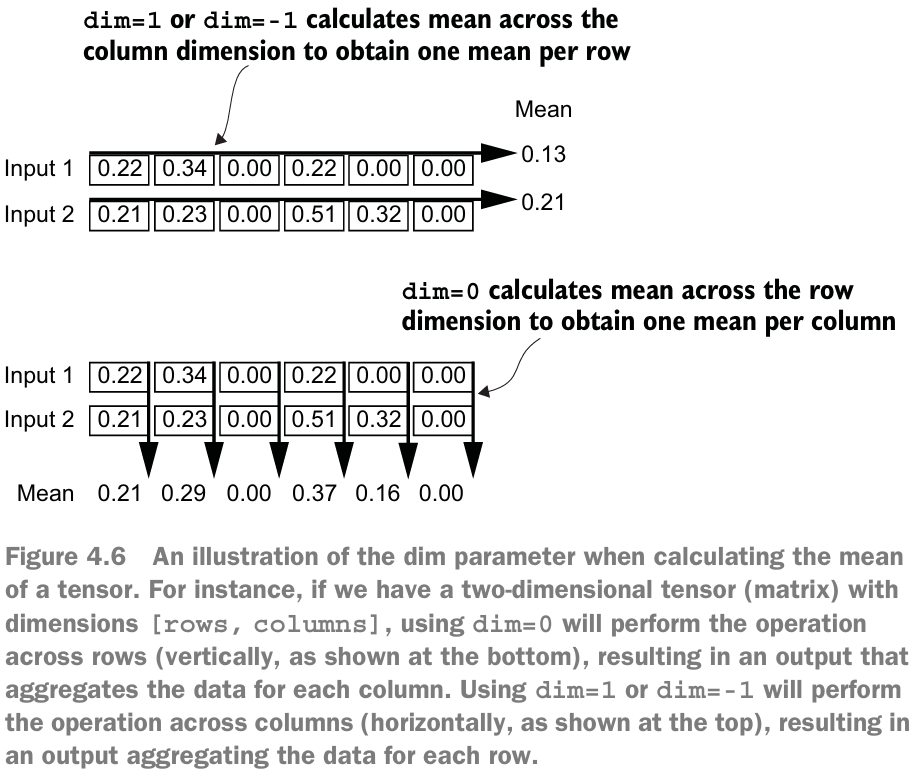

Em seguida, vamos aplicar a normalização de camadas às saídas das camadas que obtivemos anteriormente. A operação consiste em subtrair a média e dividir pela raiz quadrada da variância (também conhecida como desvio padrão):

In [ ]:
 # Aplica a normalização de camadas ao tensor 'out'.
 # out: O tensor de entrada contendo as saídas da camada antes da normalização. Forma (batch_size, num_features_out), neste caso (2, 6).
 # mean: O tensor contendo as médias calculadas para cada exemplo no lote. Forma (batch_size, 1), neste caso (2, 1).
 # var: O tensor contendo as variâncias calculadas para cada exemplo no lote. Forma (batch_size, 1), neste caso (2, 1).
 # torch.sqrt(var): Calcula a raiz quadrada da variância, que é o desvio padrão.
 # (out - mean): Subtrai a média de cada elemento correspondente no tensor 'out'.
 #               Graças ao broadcasting do PyTorch, o tensor 'mean' (2, 1) é estendido para (2, 6) para corresponder à forma de 'out',
 #               permitindo a subtração elemento a elemento ao longo da última dimensão.
 # (out - mean) / torch.sqrt(var): Divide o resultado da subtração pelo desvio padrão.
 #                                  Novamente, o broadcasting aplica o desvio padrão (2, 1) a cada elemento correspondente ao longo da última dimensão.
 # out_norm: O tensor resultante após a normalização. Cada linha (exemplo) agora tem média próxima de 0 e variância próxima de 1.
 #           A forma de out_norm é a mesma de out: (2, 6).
 out_norm = (out - mean) / torch.sqrt(var)

 # Calcula a média do tensor normalizado 'out_norm'.
 # out_norm: O tensor normalizado calculado na linha anterior. Forma (2, 6).
 # .mean(): Método para calcular a média.
 # dim=-1: Calcula a média ao longo da última dimensão (as 6 características de saída para cada exemplo).
 # keepdim=True: Mantém a dimensão calculada, resultando em um tensor de forma (2, 1).
 # mean: Esta variável agora armazena as médias das linhas do tensor NORMALIZADO. Espera-se que esses valores sejam próximos de 0.
 mean = out_norm.mean(dim=-1, keepdim=True)

 # Calcula a variância do tensor normalizado 'out_norm'.
 # out_norm: O tensor normalizado calculado anteriormente. Forma (2, 6).
 # .var(): Método para calcular a variância.
 # dim=-1: Calcula a variância ao longo da última dimensão (as 6 características de saída para cada exemplo).
 # keepdim=True: Mantém a dimensão calculada, resultando em um tensor de forma (2, 1).
 # var: Esta variável agora armazena as variâncias das linhas do tensor NORMALIZADO. Espera-se que esses valores sejam próximos de 1.
 var = out_norm.var(dim=-1, keepdim=True)

 # Imprime o rótulo "Normalized layer outputs:" seguido por uma nova linha.
 print("Normalized layer outputs:\n", out_norm)
 # Imprime o tensor 'out_norm'.
 # Interpretação: Você verá um tensor 2x6. Cada linha representa um exemplo de entrada,
 #                mas agora os valores dentro de cada linha foram ajustados de forma que a média
 #                desses valores seja próxima de 0 e a variância seja próxima de 1.
 #                Note que os valores podem ser negativos, ao contrário da saída original após a ReLU.

 # Imprime o rótulo "Mean:" seguido por uma nova linha.
 print("Mean:\n", mean)
 # Imprime o tensor 'mean' (as médias das linhas do tensor normalizado).
 # Interpretação: Você verá um tensor 2x1. Os valores devem ser muito próximos de 0 (devido à normalização).
 #                Pequenas variações podem ocorrer devido a imprecisões de ponto flutuante.

 # Imprime o rótulo "Variance:" seguido por uma nova linha.
 print("Variance:\n", var)
 # Imprime o tensor 'var' (as variâncias das linhas do tensor normalizado).
 # Interpretação: Você verá um tensor 2x1. Os valores devem ser muito próximos de 1 (devido à normalização).
 #                Pequenas variações podem ocorrer devido a imprecisões de ponto flutuante ou ao uso de estimadores de variância (viesado vs não viesado).

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Como podemos ver com base nos resultados, as saídas da camada normalizada, que agora também contêm valores negativos, têm média 0 e variância 1.

Observe que o valor $–5,9605e-08$ no tensor de saída é a notação científica para $–5,9605 × 10^{-8}$, que é $–0,000000059605$ na forma decimal. Este valor é muito próximo de 0, mas não é exatamente 0 devido a pequenos erros numéricos que podem se acumular devido à precisão finita com que os computadores representam números.

Para melhorar a legibilidade, também podemos desativar a notação científica ao imprimir valores do tensor, definindo `sci_mode` como `False`:

In [ ]:
 # Define as opções de impressão global para tensores PyTorch.
 # torch.set_printoptions(): Esta função permite configurar como os tensores PyTorch são exibidos quando impressos.
 # sci_mode=False: Este parâmetro controla se a notação científica (por exemplo, 1.23e-04) deve ser usada ao imprimir tensores.
 #                 Definindo-o como False, os números serão impressos em formato decimal padrão, tornando-os mais legíveis
 #                 para valores próximos de zero ou muito grandes/pequenos.
 # Interpretação: Após executar esta linha, qualquer tensor impresso no console ou saída do notebook usará notação decimal
 #                em vez de notação científica, a menos que a notação científica seja estritamente necessária para representar
 #                o valor com precisão devido ao seu tamanho.
 torch.set_printoptions(sci_mode=False)

 # Imprime o rótulo "Mean:" seguido por uma nova linha.
 print("Mean:\n", mean)
 # Imprime o tensor 'mean'.
 # mean: Este tensor contém as médias calculadas anteriormente (das saídas da camada normalizada).
 #       Sua forma é (batch_size, 1), neste caso (2, 1).
 # Interpretação: Você verá um tensor 2x1 exibido em formato decimal (devido à linha anterior). Cada valor
 #                neste tensor representa a média da linha correspondente no tensor normalizado 'out_norm'.
 #                Como 'out_norm' foi normalizado para ter média 0, esses valores devem ser muito próximos de 0.

 # Imprime o rótulo "Variance:" seguido por uma nova linha.
 print("Variance:\n", var)
 # Imprime o tensor 'var'.
 # var: Este tensor contém as variâncias calculadas anteriormente (das saídas da camada normalizada).
 #      Sua forma é (batch_size, 1), neste caso (2, 1).
 # Interpretação: Você verá um tensor 2x1 exibido em formato decimal. Cada valor neste tensor
 #                representa a variância da linha correspondente no tensor normalizado 'out_norm'.
 #                Como 'out_norm' foi normalizado para ter variância 1, esses valores devem ser muito próximos de 1.

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Até agora, codificamos e aplicamos a normalização de camadas em um processo passo a passo. Vamos agora encapsular esse processo em um módulo PyTorch que poderemos usar no modelo GPT posteriormente.

In [ ]:
class LayerNorm(nn.Module):
    # Define a classe LayerNorm que herda de nn.Module.
    # nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
    # Herdar dela permite que o PyTorch gerencie esta classe como parte de uma rede neural,
    # incluindo o rastreamento de parâmetros, o movimento para diferentes dispositivos (CPU/GPU), etc.

    def __init__(self, emb_dim):
        # Método construtor da classe LayerNorm.
        # Este método é chamado quando você cria uma instância da classe (ex: layer_norm = LayerNorm(768)).
        # emb_dim: Inteiro que especifica a dimensão das características (embedding dimension) que serão normalizadas.
        #          Em um modelo Transformer, esta seria geralmente a dimensão de embedding.

        super().__init__()
        # Chama o construtor da classe pai (nn.Module).
        # Isso é crucial para a inicialização correta do módulo PyTorch.
        # Ele configura coisas como o registro de parâmetros e sub-módulos.

        self.eps = 1e-5
        # Define uma pequena constante epsilon (eps).
        # Este valor é adicionado ao denominador (variância) durante o cálculo da normalização para evitar divisão por zero,
        # o que pode acontecer se a variância for zero (por exemplo, quando todos os valores em uma dimensão são iguais).
        # 1e-5 (0.00001) é um valor pequeno e comum para garantir estabilidade numérica.

        self.scale = nn.Parameter(torch.ones(emb_dim))
        # Cria um parâmetro aprendível chamado 'scale' (escala ou ganho).
        # nn.Parameter é uma subclasse de Tensor que automaticamente é registrada como um parâmetro do módulo.
        # torch.ones(emb_dim): Cria um tensor com todos os valores iguais a 1.
        #                      A forma deste tensor é (emb_dim,), ou seja, um tensor 1D com 'emb_dim' elementos.
        #                      Este tensor 'scale' terá um elemento para cada característica na dimensão normalizada.
        # Durante o treinamento, o PyTorch calculará gradientes para 'self.scale' e o otimizador ajustará seus valores.
        # Interpretação: 'scale' permite que o modelo aprenda a escalar os valores normalizados. Inicialmente, ele não altera os valores (multiplicado por 1).

        self.shift = nn.Parameter(torch.zeros(emb_dim))
        # Cria um parâmetro aprendível chamado 'shift' (deslocamento ou bias).
        # nn.Parameter: Registra este tensor como um parâmetro do módulo.
        # torch.zeros(emb_dim): Cria um tensor com todos os valores iguais a 0.
        #                       A forma deste tensor é (emb_dim,), correspondendo a um valor de bias para cada característica.
        # Durante o treinamento, o PyTorch calculará gradientes para 'self.shift' e o otimizador ajustará seus valores.
        # Interpretação: 'shift' permite que o modelo aprenda a deslocar (adicionar/subtrair) os valores normalizados. Inicialmente, ele não altera os valores (somado por 0).

    def forward(self, x):
        # Método forward define a passagem para frente do módulo LayerNorm.
        # Este método é chamado quando você "chama" a instância do módulo com um tensor de entrada (ex: output = layer_norm(input_tensor)).
        # x: O tensor de entrada para esta camada de normalização.
        #    Em um modelo Transformer, 'x' seria a saída de uma camada anterior (ex: após a atenção ou a feed-forward).
        #    A forma típica de 'x' seria (batch_size, seq_len, emb_dim).
        #    A normalização é aplicada na última dimensão (emb_dim).

        mean = x.mean(dim=-1, keepdim=True)
        # Calcula a média dos elementos no tensor 'x'.
        # .mean(): Método para calcular a média.
        # dim=-1: Especifica a dimensão ao longo da qual a média é calculada. -1 se refere à última dimensão do tensor, que é 'emb_dim'.
        #         A média é calculada INDIVIDUALMENTE para cada sequência no lote e para cada posição na sequência,
        #         mas *através* de todas as características na dimensão 'emb_dim'.
        # keepdim=True: Garante que a dimensão ao longo da qual a média foi calculada seja mantida, mas com tamanho 1.
        #               Se x tem forma (batch_size, seq_len, emb_dim), 'mean' terá forma (batch_size, seq_len, 1).
        # Interpretação: 'mean' contém a média das características para cada token em cada amostra do lote.

        var = x.var(dim=-1, keepdim=True, unbiased=False)
        # Calcula a variância dos elementos no tensor 'x'.
        # .var(): Método para calcular a variância.
        # dim=-1: Especifica a dimensão ao longo da qual a variância é calculada (a última dimensão, 'emb_dim').
        #         A variância é calculada INDIVIDUALMENTE para cada sequência e posição, *através* das características.
        # keepdim=True: Mantém a dimensão calculada com tamanho 1. A forma de 'var' será (batch_size, seq_len, 1).
        # unbiased=False: Especifica que o estimador viesado (dividido por n) deve ser usado para a variância, em vez do estimador não viesado (dividido por n-1), que é o padrão em algumas versões do PyTorch ou bibliotecas como NumPy. O uso de unbiased=False é comum em Layer Normalization.
        # Interpretação: 'var' contém a variância das características para cada token em cada amostra do lote.

        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        # Aplica a fórmula de normalização.
        # (x - mean): Subtrai a média de cada elemento correspondente no tensor 'x'.
        #             Graças ao broadcasting, 'mean' (batch_size, seq_len, 1) é estendido para (batch_size, seq_len, emb_dim)
        #             para corresponder à forma de 'x', permitindo a subtração elemento a elemento ao longo da última dimensão.
        # var + self.eps: Adiciona o pequeno valor epsilon à variância para evitar divisão por zero.
        # torch.sqrt(var + self.eps): Calcula o desvio padrão (raiz quadrada da variância com epsilon).
        # (x - mean) / torch.sqrt(var + self.eps): Divide a diferença pela média pelo desvio padrão.
        #                                           O broadcasting aplica o desvio padrão (batch_size, seq_len, 1)
        #                                           a cada elemento correspondente ao longo da última dimensão.
        # norm_x: O tensor resultante após a normalização. Cada vetor de características (ao longo da dimensão 'emb_dim')
        #         para cada token em cada amostra agora tem média próxima de 0 e variância próxima de 1.
        #         A forma de 'norm_x' é a mesma de 'x': (batch_size, seq_len, emb_dim).
        # Interpretação: Este é o passo central da normalização, ajustando os valores para uma escala padrão.

        return self.scale * norm_x + self.shift
        # Aplica os parâmetros aprendíveis 'scale' e 'shift'.
        # self.scale * norm_x: Multiplica os valores normalizados pelo tensor 'scale' (ganho).
        #                      Graças ao broadcasting, 'self.scale' (emb_dim,) é estendido para (batch_size, seq_len, emb_dim)
        #                      para permitir a multiplicação elemento a elemento.
        # ... + self.shift: Adiciona o tensor 'shift' (bias) ao resultado da multiplicação.
        #                   Novamente, o broadcasting aplica 'self.shift' (emb_dim,) de forma adequada.
        # Interpretação: Estes parâmetros permitem que a normalização da camada aprenda uma transformação de identidade (se scale=1, shift=0)
        #                ou ajuste a escala e o deslocamento dos valores normalizados para otimizar o desempenho do modelo durante o treinamento.
        # Retorna o tensor final após normalização, escalonamento e deslocamento.

Esta implementação específica de normalização de camadas opera na última dimensão do tensor de entrada x, que representa a dimensão de incorporação (`emb_dim`). A variável `eps` é uma pequena constante (épsilon) adicionada à variância para evitar a divisão por zero durante a normalização. `scale` e `shift` são dois parâmetros treináveis (da mesma dimensão da entrada) que o LLM ajusta automaticamente durante o treinamento se for determinado que isso melhoraria o desempenho do modelo em sua tarefa de treinamento. Isso permite que o modelo aprenda a escala e o deslocamento apropriados que melhor se adaptam aos dados que está processando.

---

$\large \textbf{Variancia Viesada}$

Em nosso método de cálculo de variância, usamos um detalhe de implementação definindo `unbiased=False`. Para aqueles curiosos sobre o que isso significa, no cálculo de variância, dividimos pelo número de entradas ***n*** na fórmula de variância. Essa abordagem não aplica a correção de Bessel, que normalmente usa ***n – 1*** em vez de ***n*** no denominador para ajustar o viés na estimativa da variância da amostra. Essa decisão resulta em uma estimativa chamada de variância tendenciosa. Para LLMs, onde a dimensão de incorporação ***n*** é significativamente grande, a diferença entre usar ***n*** e ***n – 1*** é praticamente insignificante. Escolhi essa abordagem para garantir a compatibilidade com as camadas de normalização do modelo GPT-2 e porque ela reflete o comportamento padrão do TensorFlow, que foi usado para implementar o modelo GPT-2 original. Usar uma configuração semelhante garante que nosso método seja compatível com os pesos pré-treinados que carregaremos no capítulo 6.

---

Vamos agora testar o módulo `LayerNorm` na prática e aplicá-lo à entrada em lote:

In [ ]:
 # Cria uma instância da classe LayerNorm.
 # LayerNorm: A classe que implementa a normalização de camadas que definimos anteriormente.
 # emb_dim=5: Passa o argumento emb_dim com o valor 5 para o construtor (__init__) da classe LayerNorm.
 #            Isso configura a camada LayerNorm para operar em tensores cuja última dimensão (a dimensão de características)
 #            tem tamanho 5. Isso corresponde à dimensão de entrada do nosso 'batch_example' (2, 5).
 # ln: Variável que armazena a instância criada da camada LayerNorm.
 ln = LayerNorm(emb_dim=5)

 # Aplica a instância da LayerNorm ('ln') ao tensor 'batch_example'.
 # ln(...): Chama o método forward() da instância 'ln', passando 'batch_example' como entrada.
 # batch_example: O tensor de entrada, que neste caso é o tensor criado com torch.randn(2, 5). Sua forma é (2, 5).
 # out_ln: Variável que armazena o tensor resultante após a aplicação da normalização de camadas.
 #         A forma de 'out_ln' será a mesma de 'batch_example', ou seja, (2, 5).
 out_ln = ln(batch_example)

 # Calcula a média do tensor normalizado 'out_ln'.
 # out_ln: O tensor de entrada para este cálculo, que é a saída da LayerNorm. Sua forma é (2, 5).
 # .mean(): Método para calcular a média.
 # dim=-1: Calcula a média ao longo da última dimensão (as 5 características de entrada para cada exemplo).
 # keepdim=True: Mantém a dimensão calculada.
 # mean: Variável que armazena a média calculada. Espera-se que seja próximo de 0.
 mean = out_ln.mean(dim=-1, keepdim=True)

 # Calcula a variância do tensor normalizado 'out_ln'.
 # out_ln: O tensor de entrada para este cálculo. Sua forma é (2, 5).
 # .var(): Método para calcular a variância.
 # dim=-1: Calcula a variância ao longo da última dimensão (as 5 características de entrada para cada exemplo).
 # unbiased=False: Usa o estimador viesado (divide por n).
 # keepdim=True: Mantém a dimensão calculada.
 # var: Variável que armazena a variância calculada. Espera-se que seja próximo de 1.
 var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

 # Imprime o rótulo "Mean:" seguido por uma nova linha.
 print("Mean:\n", mean)
 # Imprime o tensor 'mean'.
 # Interpretação: Você verá a média do tensor normalizado. Espera-se que seja muito próximo de 0.

 # Imprime o rótulo "Variance:" seguido por uma nova linha.
 print("Variance:\n", var)
 # Imprime o tensor 'var'.
 # Interpretação: Você verá a variância do tensor normalizado. Espera-se que seja muito próximo de 1.

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Os resultados mostram que o código de normalização da camada funciona conforme o esperado e normaliza os valores de cada uma das duas entradas de modo que elas tenham uma média de 0 e uma variância de 1.

Já cobrimos dois dos blocos de construção necessários para implementar a arquitetura GPT, como mostrado na figura 4.7. Em seguida, veremos a função de ativação GELU, que é uma das funções de ativação usadas em LLMs, em vez da função ReLU tradicional que usamos anteriormente.

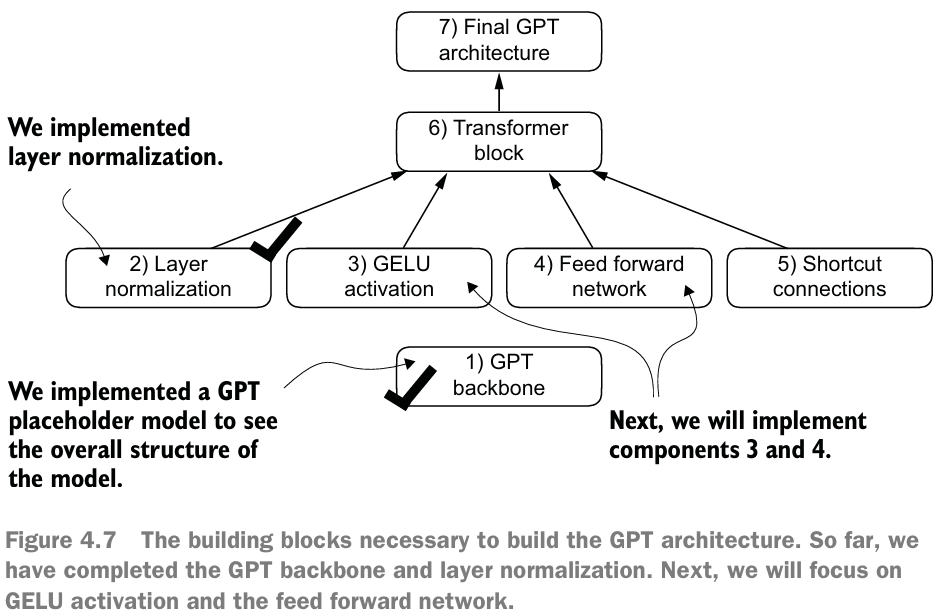

---

$\large \textbf{Normalizacao de Camadas vs. Normalizacao de Lotes}$

Se você conhece a normalização em lote, um método de normalização comum e tradicional para redes neurais, pode se perguntar como ela se compara à normalização em camadas. Ao contrário da normalização em lote, que normaliza em toda a dimensão do lote, a normalização em camadas normaliza em toda a dimensão dos recursos. LLMs geralmente exigem recursos computacionais significativos, e o hardware disponível ou o caso de uso específico podem determinar o tamanho do lote durante o treinamento ou a inferência. Como a normalização em camadas normaliza cada entrada independentemente do tamanho do lote, ela oferece mais flexibilidade e estabilidade nesses cenários. Isso é particularmente benéfico para treinamento distribuído ou ao implantar modelos em ambientes com recursos limitados.

---

## **3 - Implementando uma Rede de Feed Forward com Ativações GELU**

A seguir, implementaremos um pequeno submódulo de rede neural usado como parte do bloco transformador em LLMs. Começaremos implementando a função de ativação GELU,
que desempenha um papel crucial neste submódulo de rede neural.

---
**NOTA:** Para obter informações adicionais sobre a implementação de redes neurais no PyTorch, consulte a seção A.5 no apêndice A.

---

Historicamente, a função de ativação ReLU tem sido comumente usada em aprendizado profundo devido à sua simplicidade e eficácia em diversas arquiteturas de redes neurais. No entanto, em LLMs, diversas outras funções de ativação são empregadas além da ReLU tradicional. Dois exemplos notáveis são GELU (*unidade linear de erro gaussiano*) e SwiGLU (*unidade linear com porta Swish*).

GELU e SwiGLU são funções de ativação mais complexas e suaves, incorporando unidades lineares gaussianas e sigmoides, respectivamente. Elas oferecem desempenho aprimorado para modelos de aprendizado profundo, ao contrário do ReLU, que é mais simples.

A função de ativação GELU pode ser implementada de diversas maneiras; a versão exata é definida como $GELU(x) = x \cdot \Phi(x)$, onde $\Phi(x)$ é a função de distribuição cumulativa da distribuição gaussiana padrão. Na prática, no entanto, é comum implementar uma aproximação computacionalmente mais barata (o modelo GPT-2 original também foi treinado com essa aproximação, que foi encontrada por meio de ajuste de curva):

$$
GELU(x) \simeq 0.5 \cdot x \cdot \left(1 + tanh\left[\sqrt{\dfrac{2}{\pi}} \cdot (x + 0.044715 \cdot x^{3}) \right] \right)
$$

No código, podemos implementar essa função como um módulo PyTorch.

In [ ]:
class GELU(nn.Module):
    # Define a classe GELU que herda de nn.Module.
    # nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
    # Herdar dela permite que o PyTorch gerencie esta classe como parte de uma rede neural.

    def __init__(self):
        # Método construtor da classe GELU.
        # Este método é chamado quando você cria uma instância da classe (ex: activation = GELU()).
        # Esta função de ativação não possui parâmetros treináveis, então o construtor é simples.

        super().__init__()
        # Chama o construtor da classe pai (nn.Module).
        # Isso é crucial para a inicialização correta do módulo PyTorch.

    def forward(self, x):
        # Método forward define a passagem para frente do módulo GELU.
        # Este método é chamado quando você "chama" a instância do módulo com um tensor de entrada (ex: output = activation(input_tensor)).
        # x: O tensor de entrada para esta função de ativação.
        #    A forma de 'x' pode ser qualquer, pois a operação é aplicada elemento a elemento.

        # Esta linha implementa uma aproximação da função de ativação GELU.
        # A fórmula implementada é: 0.5 * x * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))
        return 0.5 * x * (1 + torch.tanh(
            # torch.tanh(): Aplica a função tangente hiperbólica elemento a elemento ao tensor resultante da expressão interna.
            # Esta função comprime os valores no intervalo [-1, 1].
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            # torch.sqrt(): Calcula a raiz quadrada do valor dentro dos parênteses.
            # torch.tensor(2.0 / torch.pi): Cria um tensor constante contendo o valor de 2 dividido por pi.
            #                              torch.pi é uma constante em PyTorch que representa o valor de pi.
            #                              Este termo (sqrt(2/pi)) é uma constante na fórmula de aproximação do GELU.
            (x + 0.044715 * torch.pow(x, 3))
            # (x + ...): Soma o tensor de entrada 'x' com o termo seguinte.
            # 0.044715: Uma constante numérica usada na aproximação da fórmula do GELU.
            # torch.pow(x, 3): Calcula a terceira potência (cubo) de cada elemento no tensor 'x' elemento a elemento.
            # 0.044715 * torch.pow(x, 3): Multiplica a constante pelo cubo do tensor de entrada 'x' elemento a elemento.
            # (x + 0.044715 * torch.pow(x, 3)): Soma o tensor de entrada 'x' com o resultado da multiplicação.
            #                                   Esta parte da fórmula ajuda a modelar a forma suave da função GELU.
        ))
        # 0.5 * x * (...): Multiplica 0.5 pelo tensor de entrada 'x' e pelo resultado da expressão dentro dos parênteses externos.
        #                  Esta multiplicação final ajusta a escala da saída.
        # Interpretação: O método forward calcula o valor da função GELU para cada elemento do tensor de entrada 'x'
        #                e retorna um novo tensor com os resultados. Esta função de ativação introduz não linearidade
        #                no modelo, permitindo que ele aprenda padrões mais complexos.

A seguir, para ter uma ideia de como é essa função GELU e como ela se compara à função ReLU, vamos plotar essas funções lado a lado:

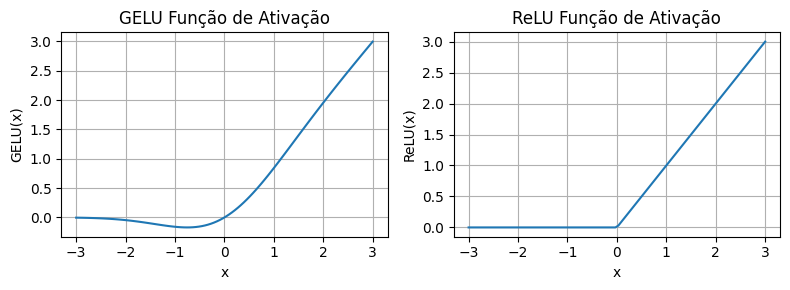

In [ ]:
import matplotlib.pyplot as plt
# Importa a biblioteca matplotlib.pyplot, que é amplamente utilizada para criar visualizações estáticas, interativas e animadas em Python.
# É convencionalmente importada com o alias plt.

gelu, relu = GELU(), nn.ReLU()
# Cria instâncias das funções de ativação GELU e ReLU.
# GELU(): Cria uma instância da nossa classe GELU personalizada que implementa a função de ativação GELU aproximada.
# nn.ReLU(): Cria uma instância da classe ReLU do módulo nn (neural networks) do PyTorch. Esta é a implementação padrão da função ReLU.
# gelu e relu são agora objetos que podem ser chamados como funções para aplicar as respectivas ativações a tensores.

x = torch.linspace(-3, 3, 100)
# Cria um tensor PyTorch chamado 'x'.
# torch.linspace(): Gera um tensor 1D contendo 'steps' pontos igualmente espaçados entre 'start' e 'end'.
# -3: O valor inicial do intervalo.
# 3: O valor final do intervalo.
# 100: O número de pontos a serem gerados no intervalo.
# Interpretação: 'x' é um tensor que representa 100 valores no eixo x, variando de -3 a 3. Estes valores serão usados como entrada para as funções de ativação para visualizá-las.

y_gelu, y_relu = gelu(x), relu(x)
# Calcula os valores de saída das funções GELU e ReLU para cada ponto no tensor 'x'.
# gelu(x): Chama o método forward() da instância 'gelu', passando o tensor 'x' como entrada. Isso aplica a função GELU a cada elemento em 'x' e retorna um novo tensor com os resultados.
# relu(x): Chama o método forward() da instância 'relu', passando o tensor 'x' como entrada. Isso aplica a função ReLU a cada elemento em 'x' e retorna um novo tensor com os resultados.
# y_gelu: Armazena os valores de saída da função GELU correspondentes a cada valor em 'x'.
# y_relu: Armazena os valores de saída da função ReLU correspondentes a cada valor em 'x'.
# Interpretação: y_gelu e y_relu são tensores que representam os valores no eixo y para os gráficos das funções GELU e ReLU, respectivamente.

plt.figure(figsize=(8, 3))
# Cria uma nova figura para o gráfico.
# plt.figure(): Cria um contêiner para os elementos do gráfico (eixos, títulos, etc.).
# figsize=(8, 3): Define o tamanho da figura em polegadas. (largura, altura).
# Interpretação: Prepara uma área onde os subplots serão desenhados, com um tamanho especificado para melhor visualização.

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    # Inicia um loop para iterar sobre as duas funções de ativação (GELU e ReLU) e seus rótulos.
    # zip([y_gelu, y_relu], ["GELU", "ReLU"]): Combina as duas listas (uma de tensores y e outra de rótulos) em pares. No primeiro loop, o par será (y_gelu, "GELU"). No segundo, será (y_relu, "ReLU").
    # enumerate(..., 1): Adiciona um contador (i) aos pares gerados pelo zip. O contador começa em 1 (devido ao '1' como segundo argumento).
    # i: O índice do loop (1 para GELU, 2 para ReLU).
    # y: O tensor de valores y para a função de ativação atual (y_gelu ou y_relu).
    # label: O rótulo da função de ativação atual ("GELU" ou "ReLU").
    # Interpretação: Este loop permite processar cada função de ativação e seu rótulo de forma conveniente para criar um subplot para cada uma.

    plt.subplot(1, 2, i)
    # Cria um subplot dentro da figura atual.
    # plt.subplot(nrows, ncols, index): Adiciona um eixo a uma grade definida por nrows e ncols, na posição index.
    # 1: Número de linhas na grade de subplots (apenas 1 linha).
    # 2: Número de colunas na grade de subplots (2 colunas).
    # i: O índice da posição do subplot na grade (1 para o primeiro subplot, 2 para o segundo).
    # Interpretação: Divide a figura em uma grade de 1 linha e 2 colunas e seleciona a posição 'i' para desenhar o gráfico atual. Isso permite colocar os gráficos GELU e ReLU lado a lado.

    plt.plot(x, y)
    # Desenha a linha do gráfico.
    # plt.plot(x_values, y_values): Desenha uma linha conectando os pontos (x_values[j], y_values[j]).
    # x: O tensor de valores x (de -3 a 3).
    # y: O tensor de valores y para a função de ativação atual (y_gelu ou y_relu).
    # Interpretação: Plota a curva da função de ativação atual no subplot selecionado.

    plt.title(f"{label} Função de Ativação")
    # Define o título do subplot atual.
    # plt.title(title_string): Define o título do eixo atual.
    # f"{label} activation function": Uma f-string que incorpora o valor da variável 'label' (GELU ou ReLU) no título.
    # Interpretação: Adiciona um título descritivo a cada gráfico (ex: "GELU activation function").

    plt.xlabel("x")
    # Define o rótulo do eixo x do subplot atual.
    # plt.xlabel(label_string): Define o rótulo do eixo x do eixo atual.
    # "x": O texto do rótulo do eixo x.
    # Interpretação: Rotula o eixo horizontal de cada gráfico como "x".

    plt.ylabel(f"{label}(x)")
    # Define o rótulo do eixo y do subplot atual.
    # plt.ylabel(label_string): Define o rótulo do eixo y do eixo atual.
    # f"{label}(x)": Uma f-string que cria um rótulo como "GELU(x)" ou "ReLU(x)".
    # Interpretação: Rotula o eixo vertical de cada gráfico com o nome da função de ativação aplicada a x.

    plt.grid(True)
    # Adiciona uma grade ao subplot atual.
    # plt.grid(boolean): Se True, exibe uma grade no eixo atual para facilitar a leitura dos valores.
    # Interpretação: Adiciona linhas de grade horizontal e vertical a cada gráfico para ajudar a visualizar os valores.

plt.tight_layout()
# Ajusta automaticamente os parâmetros do subplot para dar um layout apertado.
# Isso evita que os rótulos dos eixos ou títulos se sobreponham.
# Interpretação: Melhora a organização visual dos subplots na figura.

plt.show()
# Exibe a figura com todos os subplots.
# plt.show(): Renderiza todos os objetos Figure que foram criados e os exibe.
# Interpretação: Mostra os gráficos gerados na saída do notebook.

Como podemos ver no gráfico resultante na figura 4.8, ReLU (à direita) é uma função linear por partes que emite a entrada diretamente se for positiva; caso contrário, emite zero. GELU (à esquerda) é uma função suave e não linear que se aproxima de ReLU, mas com um gradiente diferente de zero para quase todos os valores negativos (exceto em aproximadamente x = –0,75).

A suavidade do GELU pode levar a melhores propriedades de otimização durante o treinamento, pois permite ajustes mais sutis nos parâmetros do modelo. Em contraste, o ReLU tem uma curva acentuada em zero (figura 4.18, à direita), o que às vezes pode dificultar a otimização, especialmente em redes muito profundas ou com arquiteturas complexas. Além disso, diferentemente do ReLU, que gera zero para qualquer entrada negativa, o GELU permite uma saída pequena e diferente de zero para valores negativos. Essa característica significa que, durante o processo de treinamento, os neurônios que recebem entrada negativa ainda podem contribuir para o processo de aprendizagem, embora em menor grau do que as entradas positivas.

Em seguida, vamos usar a função GELU para implementar o pequeno módulo de rede neural, `FeedForward`, que usaremos no bloco transformador do LLM mais tarde.

In [ ]:
class FeedForward(nn.Module):
    # Define a classe FeedForward que herda de nn.Module.
    # nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
    # Herdar dela permite que o PyTorch gerencie esta classe como parte de uma rede neural,
    # rastreando parâmetros, gerenciando sub-módulos, etc.

    def __init__(self, cfg):
        # Método construtor da classe FeedForward.
        # Este método é chamado quando você cria uma instância da classe (ex: ff_block = FeedForward(config)).
        # cfg: Um dicionário (ou objeto) contendo a configuração do modelo (ex: GPT_CONFIG_124M).
        #      Contém informações como a dimensão do embedding ('emb_dim').

        super().__init__()
        # Chama o construtor da classe pai (nn.Module).
        # Isso é essencial para que o PyTorch inicialize corretamente o módulo,
        # configurando o registro de parâmetros e sub-módulos.

        self.layers = nn.Sequential(
            # Define um contêiner sequencial de módulos PyTorch.
            # nn.Sequential executa seus módulos internos em ordem, passando a saída de um como entrada para o próximo.
            # 'self.layers' armazena esta sequência de camadas que compõem a rede feed-forward.

            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            # Primeira camada linear (densa).
            # nn.Linear(in_features, out_features): Cria uma camada linear que aplica uma transformação linear (Multiplicação de Matriz + Bias).
            # cfg["emb_dim"]: O número de características de entrada para esta camada. Corresponde à dimensão do embedding do modelo.
            # 4 * cfg["emb_dim"]: O número de características de saída desta camada. Em muitos modelos Transformer,
            #                     a camada intermediária da rede feed-forward tem 4 vezes a dimensão do embedding.
            #                     Esta camada projeta a entrada para um espaço de dimensão superior.

            GELU(),
            # Função de ativação GELU.
            # Esta é a nossa classe GELU personalizada (ou pode ser nn.GELU() no PyTorch moderno).
            # Aplica a função de ativação GELU elemento a elemento à saída da camada Linear anterior.
            # A função de ativação introduz não linearidade, permitindo que a rede aprenda padrões complexos.

            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            # Segunda camada linear (densa).
            # in_features = 4 * cfg["emb_dim"]: O número de características de entrada para esta camada. Corresponde ao número de saídas da camada GELU (que é o mesmo que a saída da primeira camada Linear).
            # out_features = cfg["emb_dim"]: O número de características de saída desta camada. Reduz a dimensão de volta para a dimensão do embedding original.
            #                                Esta camada projeta a saída de volta para o espaço de dimensão original do embedding.
        )
        # Interpretação do nn.Sequential: A entrada para o bloco FeedForward passa pela primeira Linear, depois pela GELU, e finalmente pela segunda Linear.

    def forward(self, x):
        # Método forward define a passagem para frente do módulo FeedForward.
        # Este método é chamado quando você "chama" a instância do módulo com um tensor de entrada (ex: output = ff_block(input_tensor)).
        # x: O tensor de entrada para o bloco FeedForward.
        #    Sua forma típica seria (batch_size, seq_len, emb_dim), onde a última dimensão é a dimensão do embedding.

        return self.layers(x)
        # Passa o tensor de entrada 'x' através da sequência de camadas definidas em 'self.layers'.
        # Chamar 'self.layers(x)' executa o método forward() de cada módulo dentro do nn.Sequential em ordem.
        # O resultado final após passar por todas as camadas na sequência é retornado.
        # Interpretação: A saída deste método é o tensor 'x' transformado pela rede feed-forward: primeiro expandido em dimensão, ativado pela GELU, e depois projetado de volta à dimensão original. A forma de saída é a mesma da entrada: (batch_size, seq_len, emb_dim).

Como podemos ver, o módulo `FeedForward` é uma pequena rede neural composta por duas camadas `Linear` e uma função de ativação `GELU`. No modelo GPT de 124 milhões de parâmetros, ele recebe os lotes de entrada com tokens com tamanho de incorporação de 768 cada, por meio do dicionário `GPT_CONFIG_124M`, onde `GPT_CONFIG_ 124M["emb_dim"] = 768`. A Figura 4.9 mostra como o tamanho da incorporação é manipulado dentro desta pequena rede neural de alimentação para a frente quando lhe passamos algumas entradas.

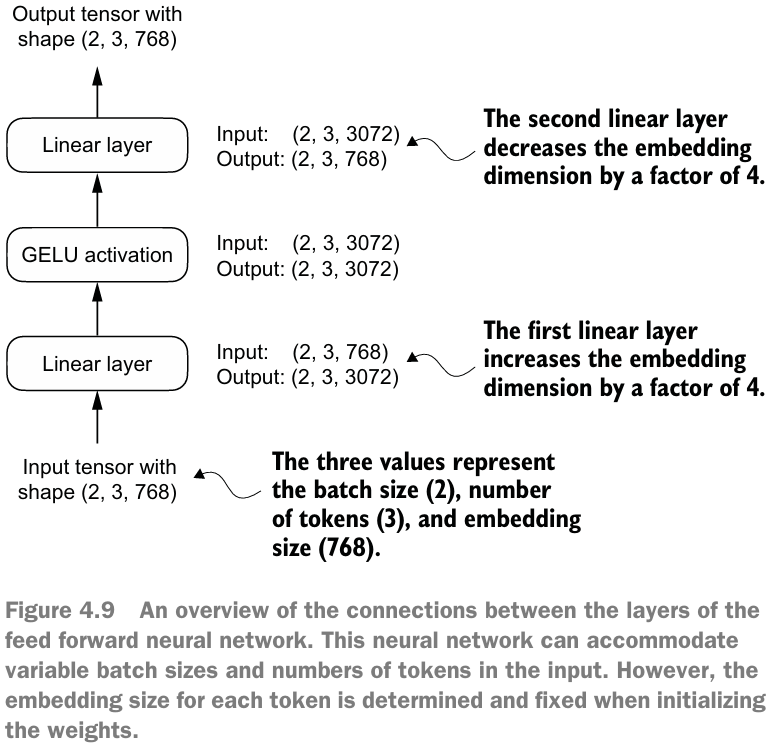

Seguindo o exemplo da figura 4.9, vamos inicializar um novo módulo `FeedForward` com um tamanho de incorporação de token de 768 e alimentá-lo com uma entrada em lote com duas amostras e três tokens cada:

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
# Cria uma instância da classe FeedForward.
# FeedForward: A classe que implementa a rede feed-forward com ativação GELU que definimos anteriormente.
# GPT_CONFIG_124M: O dicionário de configuração que contém os hiperparâmetros do modelo GPT-2 de 124M, incluindo 'emb_dim'.
#                  Este dicionário é passado para o construtor (__init__) da classe FeedForward.
# ffn: Variável que armazena a instância criada do módulo FeedForward.
# Interpretação: Esta linha inicializa a rede feed-forward com as dimensões de embedding especificadas na configuração GPT-2 (768).

x = torch.rand(2, 3, 768)
# Cria um tensor PyTorch chamado 'x' para simular a entrada para o módulo FeedForward.
# torch.rand(): Gera um tensor com números aleatórios amostrados de uma distribuição uniforme no intervalo [0, 1).
# O argumento (2, 3, 768) define a forma do tensor:
# - 2: Representa o tamanho do lote (batch size). Temos 2 sequências/amostras no lote.
# - 3: Representa o comprimento da sequência (seq_len). Cada sequência tem 3 tokens/posições.
# - 768: Representa a dimensão das características (emb_dim). Cada token é representado por um vetor de 768 dimensões.
# Interpretação: Este tensor simula a entrada típica para um bloco FeedForward em um modelo Transformer: um lote de 2 sequências, cada uma com 3 tokens, onde cada token é um vetor de 768 características.

out = ffn(x)
# Realiza a passagem para frente (forward pass) dos dados de entrada ('x') através do módulo FeedForward ('ffn').
# Chamar uma instância de nn.Module (como 'ffn') executa seu método .forward().
# Internamente, o método forward(x) da classe FeedForward é chamado.
# O tensor 'x' é passado através das camadas definidas no nn.Sequential dentro de 'ffn' (Linear -> GELU -> Linear).
# out: Variável que armazena o tensor resultante após a aplicação da rede feed-forward.
# Interpretação: Esta linha processa o tensor de entrada 'x' através das camadas da rede feed-forward, aplicando as transformações lineares e a ativação GELU. A forma de 'out' será a mesma de 'x', pois a rede feed-forward projeta a dimensão de volta ao tamanho original do embedding.

print(out.shape)
# Imprime a forma (shape) do tensor resultante 'out'.
# out.shape: Atributo de um tensor PyTorch que retorna uma tupla representando as dimensões do tensor.
# Interpretação: A saída mostrará a forma do tensor 'out'. Espera-se que seja torch.Size([2, 3, 768]),
#                confirmando que a rede feed-forward processou o tensor mantendo as dimensões do lote e da sequência,
#                e retornando a dimensão de embedding original (768).

torch.Size([2, 3, 768])


Como podemos observar, o formato do tensor de saída é o mesmo do tensor de entrada.

O módulo `FeedForward` desempenha um papel crucial no aprimoramento da capacidade do modelo de aprender e generalizar os dados. Embora as dimensões de entrada e saída deste módulo sejam as mesmas, ele expande internamente a dimensão de incorporação para um espaço de dimensão superior através da primeira camada linear, conforme ilustrado na Figura 4.10. Essa expansão é seguida por uma ativação GELU não linear e, em seguida, uma contração de volta à dimensão original com a segunda transformação linear. Tal projeto permite a exploração de um espaço de representação mais rico.

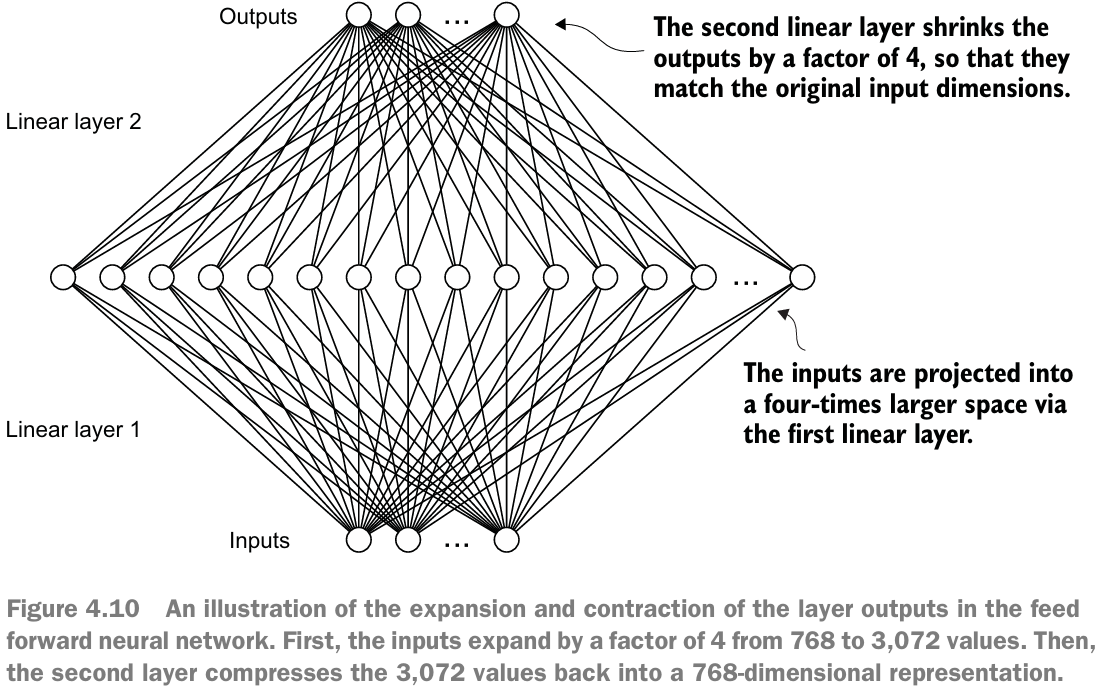

Além disso, a uniformidade nas dimensões de entrada e saída simplifica a arquitetura, permitindo o empilhamento de múltiplas camadas, como faremos posteriormente, sem a necessidade de ajustar as dimensões entre elas, tornando o modelo mais escalável.

Como mostra a figura 4.11, implementamos a maioria dos blocos de construção do LLM. A seguir, abordaremos o conceito de conexões de atalho que inserimos entre diferentes camadas de uma rede neural, importantes para melhorar o desempenho do treinamento em arquiteturas de redes neurais profundas.

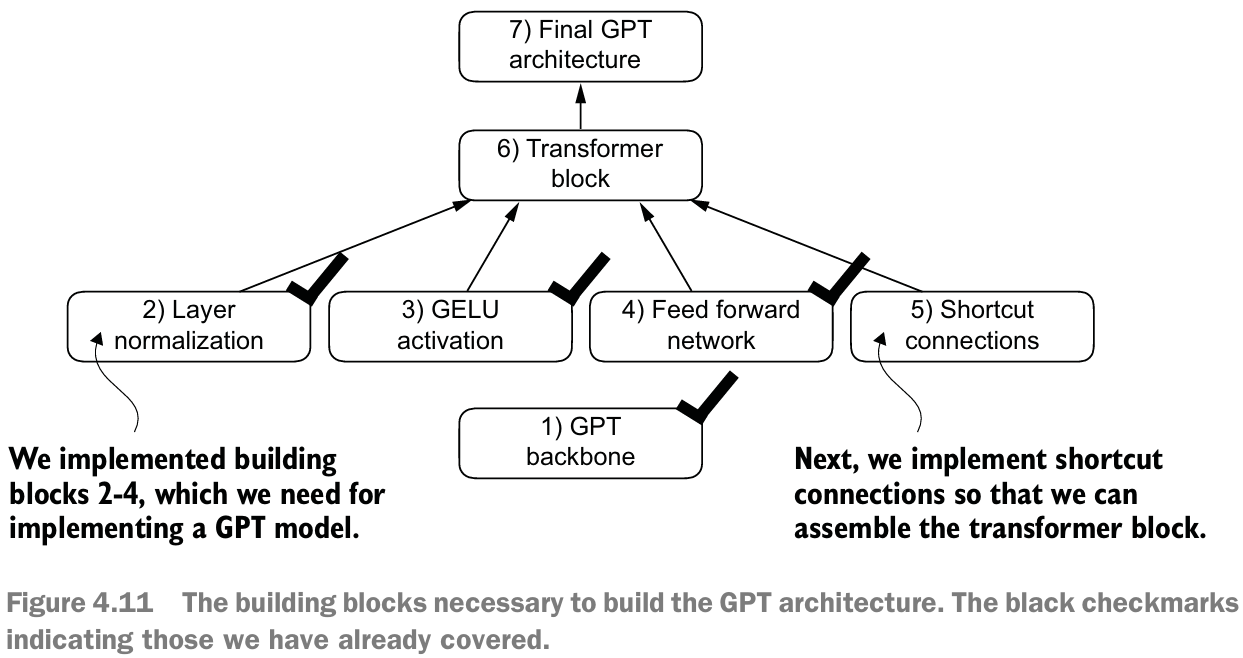

## **4 - Adicionando Conexões de Atalho**

Vamos discutir o conceito por trás das conexões de atalho, também conhecidas como conexões residuais ou de salto. Originalmente, as ***conexões de atalho*** foram propostas para redes profundas em visão computacional (especificamente, em redes residuais) para mitigar o desafio dos gradientes evanescentes. O problema do gradiente evanescente refere-se ao problema em que os gradientes (que orientam as atualizações de peso durante o treinamento) tornam-se progressivamente menores à medida que
se propagam para trás pelas camadas, dificultando o treinamento eficaz das camadas anteriores.

A Figura 4.12 mostra que uma conexão de atalho cria um caminho alternativo e mais curto para o gradiente fluir pela rede, pulando uma ou mais camadas, o que é alcançado adicionando a saída de uma camada à saída de uma camada posterior. É por isso que
essas conexões também são conhecidas como conexões de salto. Elas desempenham um papel crucial na preservação do fluxo de gradientes durante a passagem para trás no treinamento.

Na lista a seguir, implementamos a rede neural da Figura 4.12 para ver como podemos adicionar conexões de atalho no método `forward`.

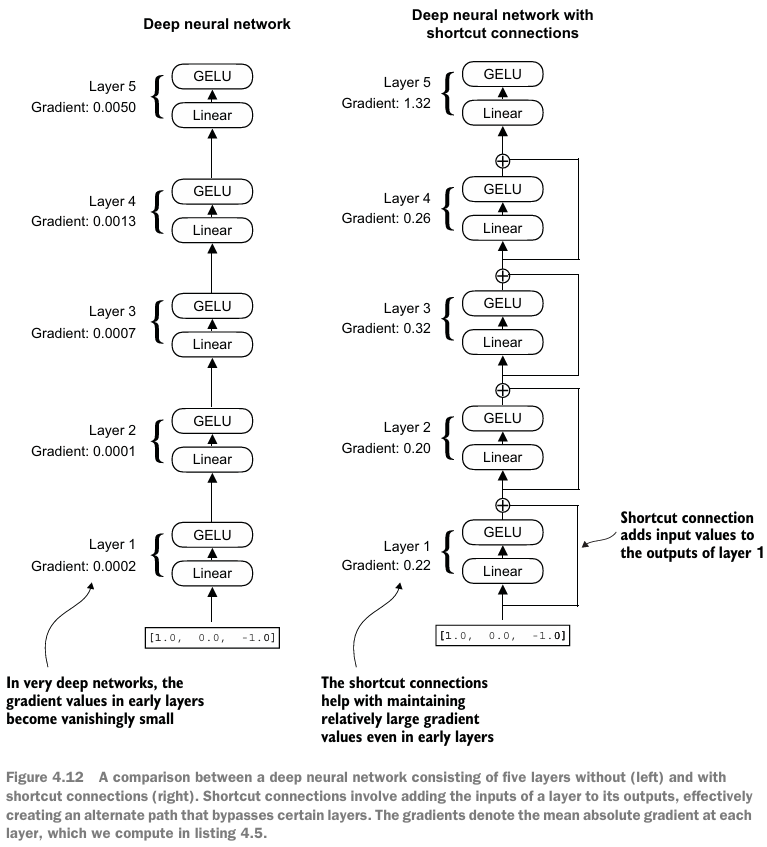

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    # Define a classe ExampleDeepNeuralNetwork que herda de nn.Module.
    # nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
    # Herdar dela permite que o PyTorch gerencie esta classe, incluindo parâmetros e sub-módulos.

    def __init__(self, layer_sizes, use_shortcut):
        # Método construtor da classe.
        # layer_sizes: Uma lista de inteiros que define o número de neurônios (ou a dimensão de saída) de cada camada.
        #              Por exemplo, [10, 20, 20, 30, 30, 40] significaria:
        #              - Entrada de dimensão 10 para a primeira camada.
        #              - Saída de dimensão 20 da primeira camada (e entrada para a segunda).
        #              - Saída de dimensão 20 da segunda camada (e entrada para a terceira).
        #              - E assim por diante.
        # use_shortcut: Um booleano (True ou False) que indica se as conexões de atalho (shortcut connections) devem ser usadas.

        super().__init__()
        # Chama o construtor da classe pai (nn.Module). Essencial para a inicialização do módulo PyTorch.

        self.use_shortcut = use_shortcut
        # Armazena o valor booleano use_shortcut como um atributo da instância.
        # Isso permite que o método forward acesse essa configuração para decidir se aplica o atalho.

        self.layers = nn.ModuleList([
             # Define uma lista de sub-módulos (camadas) da rede neural.
             # nn.ModuleList é um contêiner que armazena módulos e os registra corretamente para que sejam visíveis para o PyTorch
             # (por exemplo, para gerenciamento de parâmetros e para mover o modelo para CPU/GPU).
             # Cada elemento da lista é um nn.Sequential, que agrupa uma camada Linear e uma função de ativação GELU.

             nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                           GELU()),
             # Primeiro bloco de camada: Linear com entrada layer_sizes[0] e saída layer_sizes[1], seguida pela ativação GELU.
             # nn.Linear(layer_sizes[0], layer_sizes[1]): Camada linear que transforma a entrada.
             # GELU(): Aplica a função de ativação GELU elemento a elemento.

             nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                           GELU()),
             # Segundo bloco de camada: Linear com entrada layer_sizes[1] e saída layer_sizes[2], seguida pela ativação GELU.
             # A entrada para esta camada é a saída da camada anterior.

             nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                           GELU()),
             # Terceiro bloco de camada.

             nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                           GELU()),
             # Quarto bloco de camada.

             nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                           GELU())
             # Quinto e último bloco de camada: Linear com entrada layer_sizes[4] e saída layer_sizes[5], seguida pela ativação GELU.
         ])
        # Interpretação do nn.ModuleList: Estamos definindo uma rede neural com 5 blocos de camadas, onde cada bloco consiste em uma transformação linear seguida por uma não linearidade (GELU).

    def forward(self, x):
        # Método forward define a passagem para frente da rede neural.
        # x: O tensor de entrada para a rede neural. A forma esperada seria (batch_size, layer_sizes[0]).

        for layer in self.layers:
            # Inicia um loop que itera sobre cada bloco de camada definido em self.layers.
            # Em cada iteração, 'layer' será uma instância de um nn.Sequential contendo uma camada Linear e GELU.

            layer_output = layer(x)
            # Passa o tensor de entrada atual ('x') pelo bloco de camada atual ('layer').
            # Chamar 'layer(x)' executa o método forward() do nn.Sequential, aplicando a Linear e a GELU sequencialmente.
            # layer_output: Armazena a saída do bloco de camada atual. Sua forma será (batch_size, dimensão_de_saída_da_camada).

            if self.use_shortcut and x.shape == layer_output.shape:
                # Verifica se a conexão de atalho deve ser aplicada.
                # self.use_shortcut: Verifica se a flag use_shortcut é True.
                # x.shape == layer_output.shape: Verifica se a forma do tensor de entrada da camada atual ('x') é a mesma da forma do tensor de saída da camada atual ('layer_output').
                #                                As conexões de atalho (adição residual) só podem ser aplicadas se os tensores tiverem a mesma forma para que a adição elemento a elemento seja possível.
                # Interpretação: Esta condição é verdadeira apenas se quisermos usar atalhos E se a camada atual não mudou a dimensão do tensor (ou seja, a dimensão de entrada é igual à de saída para este bloco).

                x = x + layer_output
                # Se a condição for verdadeira, aplica a conexão de atalho.
                # Soma o tensor de entrada original da camada ('x') com o tensor de saída da camada ('layer_output').
                # O resultado desta soma se torna a nova entrada ('x') para o PRÓXIMO bloco de camada no loop.
                # Isso cria um caminho alternativo para o fluxo de informação e gradientes.

            else:
                # Se a condição 'if' for falsa (ou porque use_shortcut é False, ou porque as formas não correspondem),
                # a conexão de atalho não é aplicada.

                x = layer_output
                # Neste caso, a saída da camada ('layer_output') se torna simplesmente a nova entrada ('x') para o PRÓXIMO bloco de camada.
                # Este é o fluxo de dados tradicional em uma rede sequencial sem atalhos.

        return x
        # Após iterar por todas as camadas em self.layers, retorna o tensor 'x' resultante.
        # Este é o output final da rede neural. Sua forma será (batch_size, layer_sizes[-1]),
        # a menos que a conexão de atalho tenha sido usada em uma camada que não mudou a dimensão final.
        # No entanto, neste exemplo, as camadas são projetadas para manter a dimensão apenas se layer_sizes[i] == layer_sizes[i+1].
        # Se as dimensões mudarem em alguma camada, o atalho não será aplicado nessa camada específica.

O código implementa uma rede neural profunda com cinco camadas, cada uma composta por uma camada `Linear` e uma função de ativação `GELU`. Na passagem para frente, passamos iterativamente a entrada pelas camadas e, opcionalmente, adicionamos as conexões de atalho se o atributo `self.use_shortcut` estiver definido como `True`.

Vamos usar este código para inicializar uma rede neural sem conexões de atalho. Cada camada será inicializada de forma a aceitar um exemplo com três valores de entrada e retornar três valores de saída. A última camada retorna um único valor de saída:

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
# Define uma lista Python chamada 'layer_sizes'.
# Esta lista especifica o número de neurônios (ou a dimensão de saída) para cada camada na rede neural que será criada.
# O primeiro elemento (3) é a dimensão da entrada esperada para a primeira camada.
# Os elementos subsequentes (3, 3, 3, 3) são as dimensões de saída das camadas intermediárias.
# O último elemento (1) é a dimensão de saída da camada final da rede.
# Interpretação: Esta lista configura a arquitetura de dimensão da rede neural, indicando como os dados serão transformados entre as camadas.

sample_input = torch.tensor([[1., 0., -1.]])
# Cria um tensor PyTorch chamado 'sample_input'.
# torch.tensor(): Cria um tensor a partir de dados Python (neste caso, uma lista de listas).
# [[1., 0., -1.]]: Os dados para o tensor. É uma lista contendo uma única lista interna de três números de ponto flutuante.
#                  Isso cria um tensor 2D com forma (1, 3).
#                  - 1: Representa o tamanho do lote (batch size). Temos 1 exemplo neste lote.
#                  - 3: Representa o número de características ou a dimensão da entrada para o primeiro bloco de camada da rede (que espera entrada de dimensão 3, conforme definido em layer_sizes[0]).
# Interpretação: Este tensor simula uma única amostra de dados de entrada que será passada pela rede neural.

torch.manual_seed(123)
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a inicialização dos pesos da rede neural (que acontece quando a instância é criada na próxima linha)
# seja a mesma toda vez que o código for executado.
# Definir a semente é importante para a reprodutibilidade de experimentos e para depuração.
# O número '123' é apenas um exemplo de semente; qualquer número inteiro pode ser usado.

model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
# Cria uma instância da classe ExampleDeepNeuralNetwork.
# ExampleDeepNeuralNetwork(...): Chama o método construtor (__init__) da classe ExampleDeepNeuralNetwork.
# layer_sizes: Passa a lista 'layer_sizes' definida anteriormente como argumento. Isso configura as dimensões das camadas na rede.
# use_shortcut=False: Passa o valor booleano False para o parâmetro 'use_shortcut'.
#                     Isso instrui a rede a NÃO usar conexões de atalho (adições residuais) durante a passagem para frente.
# model_without_shortcut: Variável que armazena a instância criada da rede neural.
# Interpretação: Esta linha inicializa a rede neural profunda com a estrutura de camadas especificada e desabilita as conexões de atalho. A rede agora está pronta para receber dados de entrada através do seu método forward().

Em seguida, implementamos uma função que calcula os gradientes na passagem reversa do modelo:

In [ ]:
def print_gradients(model, x):
    # Define a função print_gradients que aceita um modelo PyTorch e um tensor de entrada.
    # model: Uma instância de um modelo PyTorch (herdeiro de nn.Module).
    # x: O tensor de entrada que será passado para o modelo.

    output = model(x)
    # Realiza a passagem para frente (forward pass) do tensor de entrada 'x' através do 'model'.
    # Chamar o modelo como uma função (model(x)) executa seu método forward(x).
    # output: Variável que armazena o tensor de saída do modelo para a entrada 'x'.

    target = torch.tensor([[0.]])
    # Cria um tensor PyTorch chamado 'target' que representa o valor alvo desejado para a saída do modelo.
    # torch.tensor([[0.]]): Cria um tensor 2D com forma (1, 1) contendo o valor 0.0.
    #                      É usado aqui para simular um alvo para calcular a perda.

    loss = nn.MSELoss()
    # Cria uma instância da função de perda Mean Squared Error (Erro Quadrático Médio).
    # nn.MSELoss: Uma classe no módulo nn do PyTorch que calcula a perda quadrática média entre a saída do modelo e o alvo.
    # loss: Variável que armazena a instância da função de perda MSE.

    loss = loss(output, target)
    # Calcula o valor da perda MSE entre a 'output' do modelo e o 'target'.
    # Chamar a instância da função de perda (loss(output, target)) calcula a diferença quadrática média
    # entre cada elemento correspondente nos tensores 'output' e 'target' e então calcula a média dessas diferenças.
    # O resultado é um tensor escalar (um tensor com um único valor) representando o valor total da perda.
    # loss: Esta variável agora armazena o valor escalar da perda calculada.

    loss.backward()
    # Realiza a passagem reversa (backward pass) para calcular os gradientes.
    # .backward(): Este método é chamado em um tensor escalar (geralmente a perda) para iniciar o processo de backpropagation.
    #              Ele calcula o gradiente da perda em relação a todos os parâmetros no modelo que têm requires_grad=True.
    #              Os gradientes são armazenados no atributo .grad de cada tensor de parâmetro.
    # Interpretação: Esta é a etapa crucial para o treinamento de redes neurais, onde os gradientes são calculados para informar como os pesos do modelo devem ser ajustados para reduzir a perda.

    for name, param in model.named_parameters():
        # Inicia um loop que itera sobre todos os parâmetros aprendíveis do modelo.
        # model.named_parameters(): Um método que retorna um iterador sobre os parâmetros do modelo,
        #                         produzindo pares de (nome do parâmetro, tensor do parâmetro).
        # name: Uma string contendo o nome do parâmetro (ex: "layers.0.0.weight").
        # param: O tensor PyTorch do parâmetro atual (ex: o tensor de pesos de uma camada Linear).

        if 'weight' in name:
            # Verifica se o nome do parâmetro contém a string 'weight'.
            # Isso filtra os parâmetros para considerar apenas as matrizes de pesos das camadas (ignorando bias, se existirem).

            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            # Imprime informações sobre o gradiente médio absoluto do parâmetro de peso atual.
            # f"{...}": Uma f-string usada para formatar a saída.
            # name: O nome do parâmetro de peso atual.
            # param.grad: Acessa o tensor de gradientes calculado na passagem reversa para o parâmetro atual.
            # .abs(): Aplica a função de valor absoluto elemento a elemento ao tensor de gradientes.
            #         Isso é feito para analisar a magnitude dos gradientes, independentemente de serem positivos ou negativos.
            # .mean(): Calcula a média de todos os valores no tensor de gradientes absolutos.
            # .item(): Converte o tensor escalar resultante da média em um valor numérico padrão Python (float).
            # Interpretação: Esta linha imprime, para cada matriz de peso no modelo, o valor médio da magnitude de seus gradientes.
            #                Isso ajuda a diagnosticar problemas como gradientes evanescentes (média próxima de zero)
            #                ou gradientes explodindo (média muito alta), que afetam a estabilidade do treinamento.

Este código especifica uma função de perda que calcula a proximidade entre a saída do modelo e um alvo especificado pelo usuário (aqui, para simplificar, o valor 0). Então, ao chamar `loss.backward()`, o PyTorch calcula o gradiente de perda para cada camada no modelo. Podemos iterar pelos parâmetros de peso via `model.named_parameters()`. Suponha que temos uma matriz de parâmetros de peso $3 × 3$ para uma determinada camada. Nesse caso, essa camada terá valores de gradiente $3 × 3$, e imprimimos o gradiente absoluto médio desses valores de gradiente $3 × 3$ para obter um único valor de gradiente por camada e comparar os gradientes entre as camadas com mais facilidade.

Em resumo, o método `.backward()` é um método conveniente no PyTorch que calcula gradientes de perda, necessários durante o treinamento do modelo, sem implementar a matemática para o cálculo do gradiente, tornando o trabalho com redes neurais profundas muito mais acessível.

---

**NOTA:** Se você não estiver familiarizado com o conceito de gradientes e treinamento de redes neurais, recomendo a leitura das seções A.4 e A.7 no apêndice A.

---

Vamos agora usar a função `print_gradients` e aplicá-la ao modelo sem pular conexões:

In [ ]:
 print_gradients(model_without_shortcut, sample_input)
 # Chama a função print_gradients que definimos anteriormente.
 # Esta função executa a passagem para frente do modelo, calcula a perda e então realiza a passagem reversa
 # para calcular os gradientes dos parâmetros do modelo.
 # model_without_shortcut: A primeira entrada para a função. É a instância da rede neural profunda que criamos anteriormente, configurada para NÃO usar conexões de atalho.
 # sample_input: A segunda entrada para a função. É o tensor PyTorch que criamos para simular um dado de entrada para a rede neural.
 # Interpretação: Ao executar esta linha, você iniciará o processo de backpropagation para a rede 'model_without_shortcut'
 #                usando 'sample_input'. A função então imprimirá a média absoluta dos gradientes para cada camada de peso
 #                nesta rede. Isso é útil para observar como os gradientes se comportam em uma rede profunda sem atalhos,
 #                potencialmente mostrando o problema do gradiente evanescente (gradientes ficando muito pequenos nas camadas iniciais).

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


A saída da função `print_gradients` mostra que os gradientes diminuem à medida que avançamos da última camada (`layers.4`) para a primeira camada (layers.0), o que é um fenômeno chamado de ***problema do gradiente evanescente***.

Vamos agora instanciar um modelo com conexões de salto e comparar:

In [ ]:
torch.manual_seed(123)
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a inicialização dos pesos da rede neural (que acontece quando a instância é criada na próxima linha)
# seja a mesma toda vez que o código for executado.
# Definir a semente é importante para a reprodutibilidade de experimentos e para depuração.
# Usamos a mesma semente do modelo anterior sem atalhos para garantir uma comparação justa na inicialização dos pesos.

model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
# Cria uma instância da classe ExampleDeepNeuralNetwork.
# ExampleDeepNeuralNetwork(...): Chama o método construtor (__init__) da classe ExampleDeepNeuralNetwork.
# layer_sizes: Passa a lista 'layer_sizes' definida anteriormente como argumento. Isso configura as dimensões das camadas na rede.
# use_shortcut=True: Passa o valor booleano True para o parâmetro 'use_shortcut'.
#                    Isso instrui a rede a USAR conexões de atalho (adições residuais) durante a passagem para frente,
#                    sempre que as formas dos tensores de entrada e saída de uma camada forem as mesmas.
# model_with_shortcut: Variável que armazena a instância criada da rede neural.
# Interpretação: Esta linha inicializa a rede neural profunda com a mesma estrutura de camadas do modelo anterior,
#                mas agora com as conexões de atalho habilitadas.

print_gradients(model_with_shortcut, sample_input)
# Chama a função print_gradients que definimos anteriormente.
# Esta função executa a passagem para frente do modelo, calcula a perda e então realiza a passagem reversa
# para calcular os gradientes dos parâmetros do modelo.
# model_with_shortcut: A primeira entrada para a função. É a instância da rede neural profunda que acabamos de criar, configurada para USAR conexões de atalho.
# sample_input: A segunda entrada para a função. É o mesmo tensor PyTorch de entrada que usamos para o modelo sem atalhos, permitindo uma comparação direta.
# Interpretação: Ao executar esta linha, você iniciará o processo de backpropagation para a rede 'model_with_shortcut'
#                usando 'sample_input'. A função então imprimirá a média absoluta dos gradientes para cada camada de peso
#                nesta rede. Comparando esta saída com a do modelo sem atalhos, você deve observar que os gradientes
#                nas camadas iniciais são significativamente maiores quando as conexões de atalho são usadas,
#                demonstrando como elas ajudam a mitigar o problema do gradiente evanescente.

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


A última camada (`layers.4`) ainda possui um gradiente maior do que as outras camadas. No entanto, o valor do gradiente se estabiliza à medida que avançamos em direção à primeira camada (`layers.0`) e não diminui para um valor extremamente pequeno.

Concluindo, conexões de atalho são importantes para superar as limitações impostas pelo problema do gradiente evanescente em redes neurais profundas. Conexões de atalho são um bloco de construção essencial de modelos muito grandes, como LLMs, e ajudarão a facilitar um treinamento mais eficaz, garantindo um fluxo de gradiente consistente entre as camadas quando treinarmos o modelo GPT no próximo capítulo.

A seguir, conectaremos todos os conceitos abordados anteriormente (normalização de camadas, ativações GELU, módulo de feedforward e conexões de atalho) em um bloco transformador, que é o bloco de construção final necessário para codificar a arquitetura GPT.

## **5 - Conectando Atencao e Camadas Lineares em um Bloco Transformador**

Agora, vamos implementar o ***bloco transformador***, um bloco de construção fundamental do GPT e de outras arquiteturas LLM. Este bloco, que é repetido uma dúzia de vezes na arquitetura GPT-2 de 124 milhões de parâmetros, combina vários conceitos que abordamos anteriormente: atenção multicabeça, normalização de camadas, dropout, camadas de feedforward e ativações GELU. Posteriormente, conectaremos este bloco transformador às partes restantes da arquitetura GPT.

A Figura 4.13 mostra um bloco transformador que combina vários componentes, incluindo o módulo de atenção multicabeça mascarado (ver Capítulo 3) e o módulo `FeedForward` que implementamos anteriormente (ver Seção 4.3). Quando um bloco transformador processa uma sequência de entrada, cada elemento na sequência (por exemplo, um token de palavra ou subpalavra) é representado por um vetor de tamanho fixo (neste caso, 768 dimensões). As operações dentro do bloco transformador, incluindo camadas de atenção multicabeça e alimentação para frente, são projetadas para transformar esses vetores de forma a preservar sua dimensionalidade.

A ideia é que o mecanismo de autoatenção no bloco de atenção multicabeça identifica e analisa as relações entre os elementos na sequência de entrada. Em contraste, a rede de feedforward modifica os dados individualmente em cada posição. Essa combinação não apenas permite uma compreensão e um processamento mais detalhados da entrada, como também aprimora a capacidade geral do modelo de lidar com padrões de dados complexos.

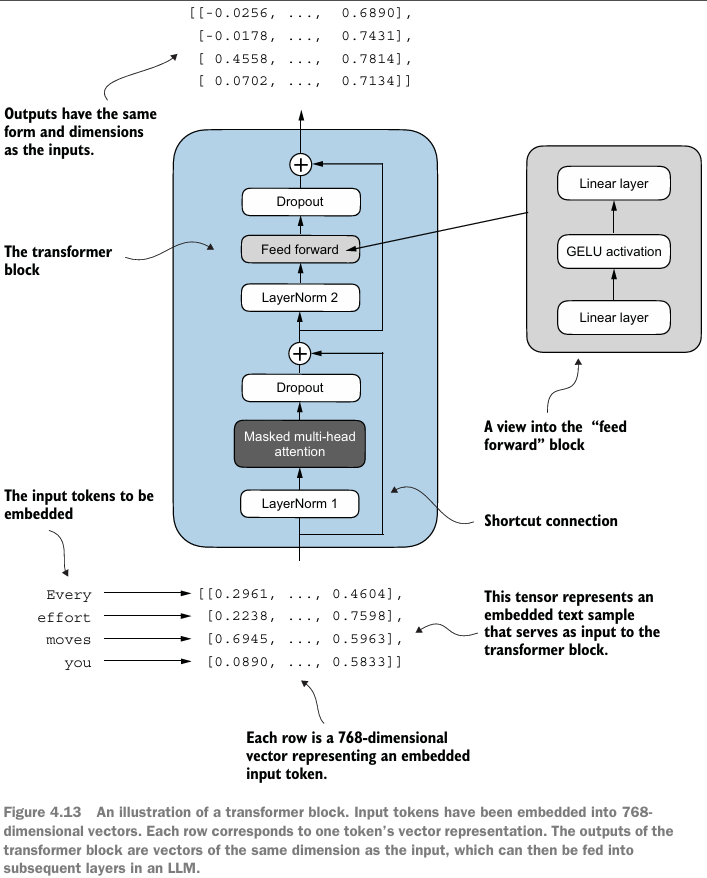

Podemos criar o `TransformerBlock` no código.

In [ ]:
# Precisamos baixar o pacote abaixo, ele permite usar funções dos capítulos anteriores
# A descrição desse pacote está no link abaixo
# https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg/llms_from_scratch
!pip install llms-from-scratch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Attempting uninstall: jupyter-client
    Found existing installation:

In [ ]:
 from llms_from_scratch.ch03 import MultiHeadAttention

In [ ]:
class TransformerBlock(nn.Module):
    # Define a classe TransformerBlock que herda de nn.Module.
    # nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
    # Herdar dela permite que o PyTorch gerencie este bloco, incluindo parâmetros e sub-módulos.
    # O TransformerBlock é um bloco de construção fundamental da arquitetura Transformer, usado repetidamente.

    def __init__(self, cfg):
        # Método construtor da classe TransformerBlock.
        # Este método é chamado quando você cria uma instância da classe (ex: trf_block = TransformerBlock(config)).
        # cfg: Um dicionário (ou objeto) contendo a configuração do modelo (ex: GPT_CONFIG_124M).
        #      Contém todos os hiperparâmetros necessários para configurar os sub-módulos.

        super().__init__()
        # Chama o construtor da classe pai (nn.Module).
        # Isso é crucial para a inicialização correta do módulo PyTorch,
        # configurando o registro de parâmetros e sub-módulos.

        self.att = MultiHeadAttention(
            # Cria uma instância do módulo MultiHeadAttention (atenção multicabeça).
            # Este módulo é responsável por permitir que o modelo pondere a importância de diferentes tokens
            # na sequência de entrada em relação à geração do próximo token.
            # Os parâmetros são passados da configuração 'cfg':
            d_in=cfg["emb_dim"], # Dimensão de entrada para a atenção. Geralmente a dimensão do embedding.
            d_out=cfg["emb_dim"], # Dimensão de saída da atenção. Geralmente a mesma que a entrada em Transformers.
            context_length=cfg["context_length"], # Comprimento máximo da sequência (tamanho da janela de contexto). Usado para mascaramento.
            num_heads=cfg["n_heads"], # Número de cabeças de atenção. Permite que o modelo foque em diferentes aspectos simultaneamente.
            dropout=cfg["drop_rate"], # Taxa de dropout para a atenção. Ajuda a prevenir overfitting.
            qkv_bias=cfg["qkv_bias"] # Se um termo de bias deve ser adicionado às projeções Query, Key, Value.
            )
        # self.att: Armazena a instância do módulo MultiHeadAttention.

        self.ff = FeedForward(cfg)
        # Cria uma instância do módulo FeedForward (rede de alimentação para a frente).
        # Este módulo processa cada posição na sequência de forma independente após a atenção.
        # cfg: O dicionário de configuração é passado para configurar o FeedForward (principalmente 'emb_dim' para definir as dimensões das camadas Linear internas).
        # self.ff: Armazena a instância do módulo FeedForward.

        self.norm1 = LayerNorm(cfg["emb_dim"])
        # Cria uma instância da primeira camada LayerNorm.
        # LayerNorm: A classe que implementa a normalização de camadas.
        # cfg["emb_dim"]: A dimensão sobre a qual a normalização será aplicada (a última dimensão do tensor de entrada/saída do bloco).
        # self.norm1: Armazena a instância da primeira LayerNorm. Em Transformers, é comum aplicar LayerNorm antes da atenção e da feed-forward.

        self.norm2 = LayerNorm(cfg["emb_dim"])
        # Cria uma instância da segunda camada LayerNorm.
        # cfg["emb_dim"]: A dimensão sobre a qual a normalização será aplicada.
        # self.norm2: Armazena a instância da segunda LayerNorm. Aplicada antes do bloco FeedForward.

        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        # Cria uma instância de Dropout.
        # nn.Dropout(p): Remove aleatoriamente (zera) elementos da entrada com probabilidade 'p' durante o treinamento.
        # cfg["drop_rate"]: A probabilidade de um elemento ser zerado, vinda da configuração do modelo.
        # self.drop_shortcut: Armazena a instância do módulo Dropout. Usado para aplicar dropout à saída dos sub-módulos (atenção e feed-forward) antes de adicioná-los à conexão de atalho.

    def forward(self, x):
        # Método forward define a passagem para frente do módulo TransformerBlock.
        # Este método é chamado quando você "chama" a instância do módulo com um tensor de entrada (ex: output = trf_block(input_tensor)).
        # x: O tensor de entrada para o TransformerBlock.
        #    Sua forma típica seria (batch_size, seq_len, emb_dim).

        # --- Primeira sub-camada: Atenção (com normalização e atalho) ---

        shortcut = x
        # Armazena o tensor de entrada atual 'x' em uma variável 'shortcut'.
        # Este tensor será usado posteriormente para a conexão de atalho (adição residual).
        # Interpretação: Salva a entrada original antes de processá-la pela normalização e atenção.

        x = self.norm1(x)
        # Aplica a primeira LayerNorm ao tensor 'x'.
        # Normaliza os valores na última dimensão do tensor de entrada.
        # x: O tensor resultante após a normalização.
        # Interpretação: Ajusta a escala e o deslocamento dos valores antes de alimentá-los para a atenção, o que pode melhorar a estabilidade do treinamento.

        x = self.att(x)
        # Passa o tensor normalizado 'x' através do módulo MultiHeadAttention.
        # O módulo de atenção calcula pesos de atenção e produz uma saída ponderada.
        # x: O tensor resultante da operação de atenção. Sua forma é a mesma da entrada (batch_size, seq_len, emb_dim).
        # Interpretação: O modelo processa as relações entre os tokens na sequência.

        x = self.drop_shortcut(x)
        # Aplica Dropout à saída do módulo de atenção.
        # Zera aleatoriamente alguns elementos da saída da atenção.
        # x: O tensor resultante após a aplicação do dropout.
        # Interpretação: Introduz regularização para evitar overfitting na saída da atenção.

        x = x + shortcut
        # Aplica a conexão de atalho (adição residual).
        # Soma a saída do sub-módulo (atenção com dropout) com o tensor 'shortcut' original (a entrada antes da normalização e atenção).
        # A adição é elemento a elemento, e as formas devem corresponder (batch_size, seq_len, emb_dim) + (batch_size, seq_len, emb_dim).
        # x: O tensor resultante após a adição residual.
        # Interpretação: Permite que o gradiente flua diretamente através da camada de atenção, ajudando a mitigar o problema do gradiente evanescente e facilitando o treinamento de redes mais profundas.

        # --- Segunda sub-camada: Feed Forward (com normalização e atalho) ---

        shortcut = x
        # Armazena o tensor de entrada atual 'x' (que agora é a saída da primeira sub-camada) em uma nova variável 'shortcut'.
        # Este tensor será usado para a conexão de atalho da segunda sub-camada.
        # Interpretação: Salva a saída da primeira sub-camada antes de processá-la pela normalização e feed-forward.

        x = self.norm2(x)
        # Aplica a segunda LayerNorm ao tensor 'x'.
        # Normaliza os valores na última dimensão do tensor.
        # x: O tensor resultante após a segunda normalização.
        # Interpretação: Ajusta a escala e o deslocamento dos valores antes de alimentá-los para a rede feed-forward.

        x = self.ff(x)
        # Passa o tensor normalizado 'x' através do módulo FeedForward.
        # O módulo FeedForward aplica transformações lineares e não lineares a cada token independentemente.
        # x: O tensor resultante da operação FeedForward. Sua forma é a mesma da entrada (batch_size, seq_len, emb_dim).
        # Interpretação: Permite que o modelo processe e transforme as representações de cada token individualmente.

        x = self.drop_shortcut(x)
        # Aplica Dropout à saída do módulo FeedForward.
        # Zera aleatoriamente alguns elementos da saída do FeedForward.
        # x: O tensor resultante após a aplicação do dropout.
        # Interpretação: Introduz regularização para evitar overfitting na saída do FeedForward.

        x = x + shortcut
        # Aplica a conexão de atalho (adição residual).
        # Soma a saída do segundo sub-módulo (FeedForward com dropout) com o tensor 'shortcut' original (a saída da primeira sub-camada).
        # A adição é elemento a elemento, e as formas devem corresponder.
        # x: O tensor resultante após a segunda adição residual.
        # Interpretação: Permite que o gradiente flua diretamente através da camada FeedForward, reforçando a conectividade e o fluxo de informação.

        return x
        # Retorna o tensor 'x', que é a saída final deste TransformerBlock.
        # Este tensor processado será a entrada para o próximo TransformerBlock na pilha (se houver)
        # ou para a camada de saída do modelo. Sua forma é a mesma da entrada original do bloco.

O código fornecido define uma classe `TransformerBlock` em PyTorch que inclui um mecanismo de atenção multi-cabeça (`MultiHeadAttention`) e uma rede de alimentação direta (`Feed
Forward`), ambos configurados com base em um dicionário de configuração fornecido (`cfg`), como `GPT_CONFIG_124M`.

A normalização de camadas (`LayerNorm`) é aplicada antes de cada um desses dois componentes, e o dropout é aplicado depois deles para regularizar o modelo e evitar overfitting. Isso também é conhecido como ***Pre-LayerNorm***. Arquiteturas mais antigas, como o modelo original do transformador, aplicavam a normalização de camadas após as redes de autoatenção e alimentação direta,
conhecida como ***Post-LayerNorm***, o que frequentemente leva a uma dinâmica de treinamento pior.

A classe também implementa o forward pass, onde cada componente é seguido por uma conexão de atalho que adiciona a entrada do bloco à sua saída. Esse recurso crítico ajuda os gradientes a fluir pela rede durante o treinamento e melhora o aprendizado de modelos profundos (consulte a seção 4.4).

Usando o dicionário `GPT_CONFIG_124M` que definimos anteriormente, vamos instanciar um bloco transformador e fornecer a ele alguns dados de exemplo:

In [ ]:
torch.manual_seed(123)
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a geração de números aleatórios para a criação do tensor 'x' e a inicialização
# dos pesos dentro do TransformerBlock sejam as mesmas a cada execução.
# Definir a semente é importante para a reprodutibilidade dos experimentos e para depuração.

x = torch.rand(2, 4, 768)
# Cria um tensor PyTorch chamado 'x' para simular a entrada para o TransformerBlock.
# torch.rand(): Gera um tensor com números aleatórios amostrados de uma distribuição uniforme no intervalo [0, 1).
# O argumento (2, 4, 768) define a forma do tensor:
# - 2: Representa o tamanho do lote (batch size). Temos 2 sequências/amostras no lote.
# - 4: Representa o comprimento da sequência (seq_len). Cada sequência tem 4 tokens/posições.
# - 768: Representa a dimensão das características (emb_dim). Cada token é representado por um vetor de 768 dimensões.
# Interpretação: Este tensor simula a entrada típica para um TransformerBlock: um lote de 2 sequências, cada uma com 4 tokens, onde cada token é um vetor de 768 características.

block = TransformerBlock(GPT_CONFIG_124M)
# Cria uma instância da classe TransformerBlock.
# TransformerBlock: A classe que implementa o bloco Transformer (atenção multicabeça, feed-forward, normalização, atalhos).
# GPT_CONFIG_124M: O dicionário de configuração que contém os hiperparâmetros do modelo GPT-2 de 124M.
#                  Este dicionário é passado para o construtor (__init__) da classe TransformerBlock
#                  para configurar os sub-módulos (MultiHeadAttention, FeedForward, LayerNorm, Dropout).
# block: Variável que armazena a instância criada do TransformerBlock.
# Interpretação: Esta linha inicializa um bloco Transformer com as especificações do modelo GPT-2 de 124M.

output = block(x)
# Realiza a passagem para frente (forward pass) dos dados de entrada ('x') através do módulo TransformerBlock ('block').
# Chamar uma instância de nn.Module (como 'block') executa seu método .forward().
# Internamente, o método forward(x) da classe TransformerBlock é chamado, processando 'x' através
# das camadas de normalização, atenção, dropout, normalização novamente, feed-forward e adições residuais.
# output: Variável que armazena o tensor resultante após a aplicação do TransformerBlock.
# Interpretação: Esta linha simula o processamento dos dados de entrada por um único bloco Transformer. O tensor 'output'
#                contém as representações dos tokens de entrada após serem transformadas pelo bloco.

print("Input shape:", x.shape)
# Imprime o rótulo "Input shape:" seguido pela forma (shape) do tensor de entrada 'x'.
# x.shape: Atributo de um tensor PyTorch que retorna uma tupla representando as dimensões do tensor.
# Interpretação: Mostra a forma do tensor que entrou no bloco Transformer.

print("Output shape:", output.shape)
# Imprime o rótulo "Output shape:" seguido pela forma (shape) do tensor de saída 'output'.
# output.shape: Atributo de um tensor PyTorch que retorna a tupla representando as dimensões do tensor de saída.
# Interpretação: Mostra a forma do tensor que saiu do bloco Transformer. Espera-se que seja a mesma da entrada
#                (batch_size, seq_len, emb_dim), confirmando que o bloco Transformer mantém a dimensionalidade.

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


Como podemos ver, o bloco transformador mantém as dimensões de entrada em sua saída, indicando que a arquitetura do transformador processa sequências de dados sem alterar sua forma em toda a rede.

A preservação da forma em toda a arquitetura do bloco transformador não é incidental, mas sim um aspecto crucial de seu projeto. Este projeto permite sua aplicação eficaz em uma ampla gama de tarefas de sequência para sequência, onde cada vetor de saída corresponde diretamente a um vetor de entrada, mantendo uma relação um-para-um. No entanto, a saída é um vetor de contexto que encapsula informações de toda a sequência de entrada (ver Capítulo 3). Isso significa que, embora as dimensões físicas da sequência (comprimento e tamanho das características) permaneçam inalteradas à medida que ela passa pelo bloco transformador, o conteúdo de cada vetor de saída é recodificado para integrar informações contextuais de toda a sequência de entrada.

Com o bloco transformador implementado, temos todos os blocos de construção necessários para implementar a arquitetura GPT. Conforme ilustrado na figura 4.14, o bloco transformador combina a normalização de camadas, a rede de alimentação direta, as ativações GELU e as conexões de atalho. Como veremos mais adiante, este bloco transformador constituirá o principal componente da arquitetura GPT.

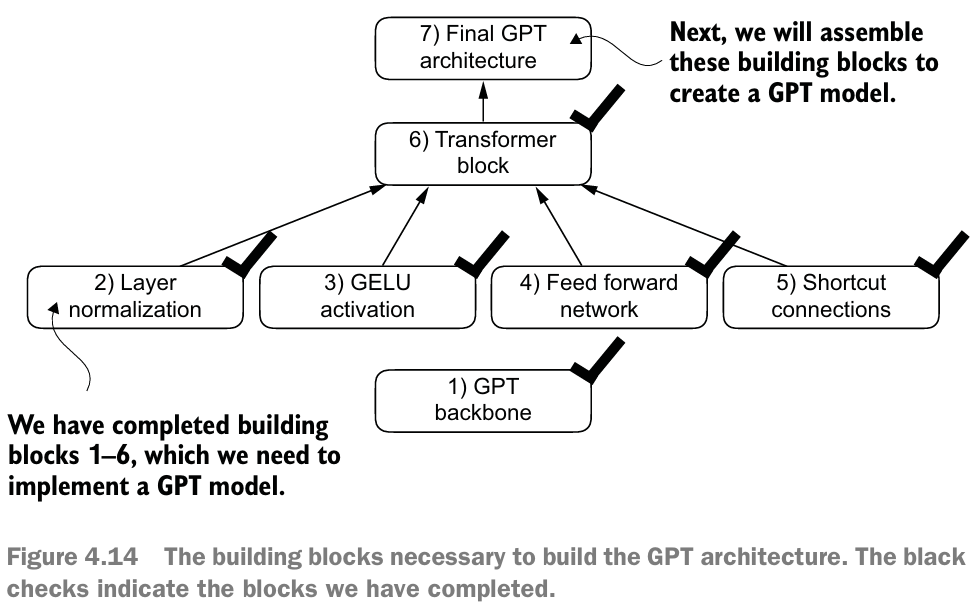

## **6 - Codificando o Modelo GPT**

Iniciamos este capítulo com uma visão geral da arquitetura GPT que chamamos de `DummyGPTModel`. Nesta implementação de código `DummyGPTModel`, mostramos as entradas e saídas do modelo GPT, mas seus blocos de construção permaneceram uma caixa preta usando as classes `DummyTransformerBlock` e `DummyLayerNorm` como marcadores de posição.

Vamos agora substituir os marcadores de posição `DummyTransformerBlock` e `DummyLayerNorm` pelas classes reais `TransformerBlock` e `LayerNorm` que codificamos anteriormente para montar uma versão totalmente funcional da versão original do GPT-2, com 124 milhões de parâmetros. No capítulo 5, pré-treinaremos um modelo GPT-2 e, no capítulo 6, carregaremos os pesos pré-treinados do OpenAI.

Antes de montarmos o modelo GPT-2 em código, vamos analisar sua estrutura geral, conforme mostrado na figura 4.15, que inclui todos os conceitos que abordamos até agora. Como podemos ver, o bloco transformador é repetido diversas vezes ao longo da arquitetura do modelo GPT. No caso do modelo GPT-2 com 124 milhões de parâmetros, ele é repetido 12 vezes, o que especificamos por meio da entrada `n_layers` no dicionário `GPT_CONFIG_124M`. Este bloco transformador é repetido 48 vezes no maior modelo GPT-2, com 1.542 milhões de parâmetros.

A saída do bloco transformador final passa então por uma etapa final de normalização da camada antes de atingir a camada de saída linear. Esta camada mapeia a saída do transformador para um espaço de alta dimensão (neste caso, 50.257 dimensões, correspondente ao tamanho do vocabulário do modelo) para prever o próximo token na sequência.

Vamos agora codificar a arquitetura da figura 4.15.

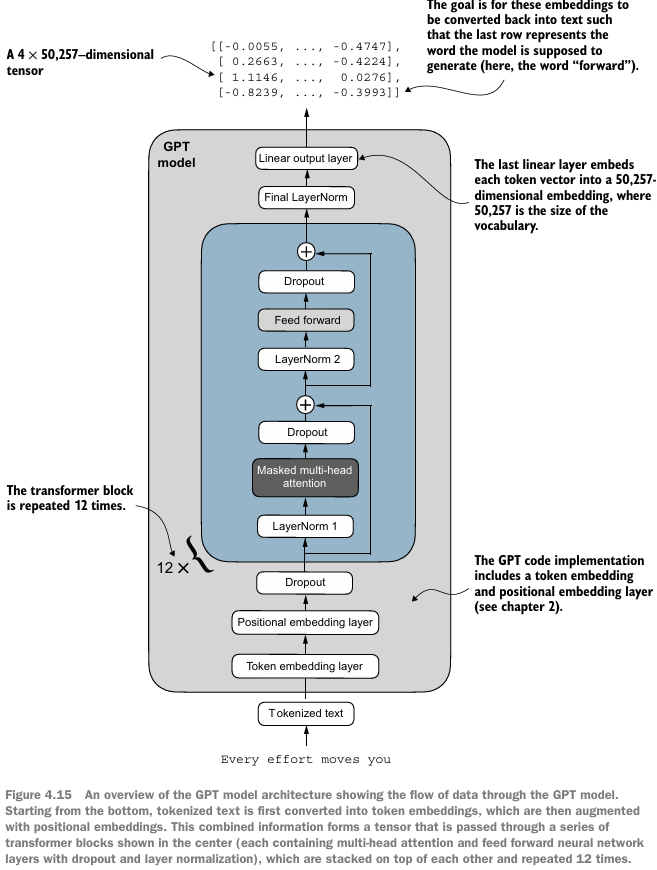

In [ ]:
class GPTModel(nn.Module):
    # Define a classe GPTModel que herda de nn.Module.
    # nn.Module é a classe base para todos os módulos de rede neural no PyTorch.
    # Herdar dela permite que o PyTorch gerencie este modelo, incluindo parâmetros e sub-módulos.
    # Esta classe representa a arquitetura completa de um modelo GPT simplificado.

    def __init__(self, cfg):
        # Método construtor da classe GPTModel.
        # Este método é chamado quando você cria uma instância do modelo (ex: gpt_model = GPTModel(config)).
        # cfg: Um dicionário (ou objeto) contendo a configuração do modelo (ex: GPT_CONFIG_124M).
        #      Contém todos os hiperparâmetros necessários para configurar as diferentes partes do modelo.

        super().__init__()
        # Chama o construtor da classe pai (nn.Module).
        # Isso é crucial para a inicialização correta do módulo PyTorch,
        # configurando o registro de parâmetros e sub-módulos.

        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # Define a camada de embedding para os tokens.
        # nn.Embedding é uma tabela de lookup que armazena vetores de embedding para cada token no vocabulário.
        # cfg["vocab_size"]: O tamanho do vocabulário (número total de tokens únicos que o modelo pode processar).
        # cfg["emb_dim"]: A dimensão do vetor de embedding para cada token. Cada token será representado por um vetor numérico deste tamanho.
        # self.tok_emb: Armazena a instância da camada de embedding de tokens.

        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # Define a camada de embedding para as posições.
        # nn.Embedding: Semelhante ao embedding de tokens, mas para posições na sequência.
        # cfg["context_length"]: O comprimento máximo da sequência (tamanho da janela de contexto) que o modelo pode manipular.
        # cfg["emb_dim"]: A dimensão do vetor de embedding para cada posição.
        # self.pos_emb: Armazena a instância da camada de embedding posicional. Estes embeddings são adicionados aos embeddings de token para fornecer informação sobre a ordem dos tokens.

        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # Define a camada de Dropout para os embeddings combinados.
        # nn.Dropout(p): Remove aleatoriamente (zera) elementos da entrada com probabilidade 'p' durante o treinamento para evitar overfitting.
        # cfg["drop_rate"]: A probabilidade de um elemento ser zerado, vinda da configuração do modelo.
        # self.drop_emb: Armazena a instância do módulo Dropout. Aplicado após a combinação dos embeddings de token e posicional.

        self.trf_blocks = nn.Sequential(
            # Define uma sequência de blocos do Transformer.
            # nn.Sequential: Contêiner para módulos que serão passados em ordem.
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])] # Cria uma lista de instâncias de TransformerBlock.
            #   - TransformerBlock(cfg): Cria uma instância de um único bloco Transformer, configurado com o dicionário 'cfg'.
            #   - for _ in range(cfg["n_layers"]): Repete a criação de um TransformerBlock pelo número de camadas especificado em cfg["n_layers"].
            #   - *[]: Desempacota a lista de TransformerBlocks para que sejam passados como argumentos individuais para nn.Sequential.
            # self.trf_blocks: Armazena a sequência de blocos Transformer empilhados. A entrada passará por cada bloco em ordem.

        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        # Define a camada de normalização final.
        # LayerNorm: A classe que implementa a normalização de camadas que definimos anteriormente.
        # cfg["emb_dim"]: A dimensão sobre a qual a normalização será aplicada (a dimensão do embedding).
        # self.final_norm: Armazena a instância da LayerNorm final. Aplicada à saída do último bloco Transformer.

        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        # Define a camada linear de saída (cabeça de classificação/previsão).
        # nn.Linear(in_features, out_features, bias): Cria uma camada linear.
        # cfg["emb_dim"]: O número de características de entrada para esta camada. Corresponde à dimensão da saída do LayerNorm final.
        # cfg["vocab_size"]: O número de características de saída desta camada. Corresponde ao tamanho do vocabulário.
        #                   Cada saída representa a pontuação (logit) para cada token possível no vocabulário.
        # bias=False: Indica que não será adicionado um termo de bias a esta camada linear, seguindo a arquitetura original do GPT-2.
        # self.out_head: Armazena a instância da camada linear de saída.

    def forward(self, in_idx):
        # Método forward define a passagem para frente do modelo GPTModel.
        # Este método é chamado quando você "chama" a instância do modelo com um tensor de entrada (ex: output = gpt_model(input_tensor)).
        # in_idx: O tensor de entrada para o modelo.
        #         Sua forma típica seria (batch_size, seq_len), onde cada elemento é um índice de token inteiro.

        batch_size, seq_len = in_idx.shape
        # Obtém o tamanho do lote (batch_size) e o comprimento da sequência (seq_len) a partir da forma do tensor de entrada 'in_idx'.

        tok_embeds = self.tok_emb(in_idx)
        # Obtém os embeddings de token para os índices de entrada.
        # self.tok_emb(in_idx): Passa o tensor de índices de token pela camada de embedding de tokens.
        #                       Para cada índice em 'in_idx', a camada retorna o vetor de embedding correspondente.
        # tok_embeds: O tensor resultante dos embeddings de token. Sua forma será (batch_size, seq_len, emb_dim).

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        # Obtém os embeddings posicionais para a sequência atual.
        # torch.arange(seq_len, device=in_idx.device): Cria um tensor 1D contendo inteiros de 0 a seq_len-1.
        #                                              Isso representa as posições de 0 até o comprimento da sequência atual.
        #                                              device=in_idx.device garante que este tensor seja criado no mesmo dispositivo (CPU/GPU) que o tensor de entrada 'in_idx'.
        # self.pos_emb(...): Passa o tensor de posições pela camada de embedding posicional.
        # pos_embeds: O tensor resultante dos embeddings posicionais. Sua forma será (seq_len, emb_dim).
        #             Graças ao broadcasting do PyTorch, este tensor (seq_len, emb_dim) será expandido para (batch_size, seq_len, emb_dim) quando adicionado a 'tok_embeds'.

        x = tok_embeds + pos_embeds
        # Combina os embeddings de token e posicional.
        # A adição é elemento a elemento. O broadcasting do 'pos_embeds' permite esta operação.
        # x: O tensor resultante dos embeddings combinados. Sua forma é (batch_size, seq_len, emb_dim).
        # Interpretação: A entrada para os blocos Transformer é a soma da representação semântica do token e sua informação posicional.

        x = self.drop_emb(x)
        # Aplica Dropout aos embeddings combinados.
        # self.drop_emb(x): Passa o tensor de embeddings combinados pelo módulo Dropout.
        # x: O tensor resultante após a aplicação do dropout.
        # Interpretação: Introduz regularização na camada de entrada para evitar overfitting.

        x = self.trf_blocks(x)
        # Passa o tensor 'x' através da sequência de blocos Transformer empilhados.
        # self.trf_blocks(x): Chama o método forward() do nn.Sequential que contém os TransformerBlocks.
        #                     A entrada 'x' passa sequencialmente por cada TransformerBlock.
        # x: O tensor resultante após ser processado por todos os blocos Transformer. Sua forma é (batch_size, seq_len, emb_dim).
        # Interpretação: Esta é a parte principal do modelo onde a atenção e as redes feed-forward transformam as representações dos tokens, incorporando contexto.

        x = self.final_norm(x)
        # Aplica a normalização de camadas final à saída do último bloco Transformer.
        # self.final_norm(x): Passa o tensor 'x' pelo módulo LayerNorm final.
        # x: O tensor resultante após a normalização final. Sua forma é (batch_size, seq_len, emb_dim).
        # Interpretação: Normaliza a saída dos blocos Transformer antes de alimentá-la para a camada de saída.

        logits = self.out_head(x)
        # Passa o tensor normalizado 'x' pela camada linear de saída.
        # self.out_head(x): Passa o tensor 'x' pela camada Linear final.
        #                  Esta camada mapeia o vetor de embedding final para um vetor de pontuações (logits) do tamanho do vocabulário.
        # logits: O tensor resultante dos logits. Sua forma é (batch_size, seq_len, vocab_size).
        # Interpretação: Para cada token em cada sequência do lote, o modelo produz uma pontuação para cada token possível no vocabulário. Essas pontuações (logits) são usadas para prever o próximo token.

        return logits
        # Retorna o tensor 'logits', que são as pontuações de saída bruta do modelo.
        # Estes logits geralmente são passados por uma função softmax para obter probabilidades de token.

Graças à classe `TransformerBlock`, a classe GPTModel é relativamente pequena e compacta.

O construtor `__init__` desta classe `GPTModel` inicializa as camadas de token e de embedding posicional usando as configurações passadas por meio de um dicionário Python, `cfg`. Essas camadas de embedding são responsáveis por converter os índices de token de entrada em vetores densos e adicionar informações posicionais (consulte o capítulo 2).

Em seguida, o método `__init__` cria uma pilha sequencial de módulos `TransformerBlock` igual ao número de camadas especificado em `cfg`. Após os blocos do transformador, uma camada `LayerNorm` é aplicada, padronizando as saídas dos blocos do transformador para estabilizar o processo de aprendizado. Por fim, uma cabeça de saída linear sem viés é definida, projetando a saída do transformador no espaço de vocabulário do tokenizador para gerar logits para cada token no vocabulário.

O método forward recebe um lote de índices de tokens de entrada, calcula seus embeddings, aplica os embeddings posicionais, passa a sequência pelos blocos do transformador, normaliza a saída final e, em seguida, calcula os logits, representando as probabilidades não normalizadas do próximo token. Converteremos esses logits em tokens e saídas de texto na próxima seção.

Vamos agora inicializar o modelo GPT de 124 milhões de parâmetros usando o dicionário `GPT_CONFIG_124M` que passamos para o parâmetro `cfg` e alimentá-lo com a entrada de texto em lote que criamos anteriormente:

In [ ]:
torch.manual_seed(123)
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a inicialização dos pesos do modelo GPTModel seja a mesma toda vez que o código for executado.
# Definir a semente é importante para a reprodutibilidade dos experimentos e para depuração.

model = GPTModel(GPT_CONFIG_124M)
# Cria uma instância da classe GPTModel.
# GPTModel: A classe que implementa a arquitetura completa do modelo GPT simplificado que definimos anteriormente.
# GPT_CONFIG_124M: O dicionário de configuração que contém os hiperparâmetros do modelo GPT-2 de 124M.
#                  Este dicionário é passado para o construtor (__init__) da classe GPTModel
#                  para configurar as camadas de embedding, os blocos Transformer, a normalização final e a cabeça de saída.
# model: Variável que armazena a instância criada do modelo GPT.
# Interpretação: Esta linha inicializa o modelo GPT com as especificações do modelo GPT-2 de 124M, incluindo o tamanho do vocabulário, comprimento do contexto, dimensão do embedding, número de cabeças de atenção e número de camadas Transformer.

out = model(batch)
# Realiza a passagem para frente (forward pass) dos dados de entrada ('batch') através do modelo GPT ('model').
# Chamar uma instância de nn.Module (como 'model') executa seu método .forward().
# Internamente, o método forward(batch) da classe GPTModel é chamado, processando 'batch' através
# das camadas de embedding, dropout, blocos Transformer, normalização final e camada de saída.
# batch: O tensor de entrada para o modelo. Sua forma é (batch_size, seq_len), onde cada elemento é um índice de token.
# out: Variável que armazena o tensor resultante após a aplicação do modelo GPT.
# Interpretação: Esta linha simula o processamento dos dados de entrada tokenizados pelo modelo GPT. O tensor 'out'
#                contém os logits de saída do modelo, que representam as pontuações para cada token possível no vocabulário,
#                para cada posição em cada sequência do lote.

print("Input batch:\n", batch)
# Imprime o rótulo "Input batch:" seguido por uma nova linha e o conteúdo do tensor de entrada 'batch'.
# batch: O tensor de entrada original contendo os índices dos tokens.
# Interpretação: Mostra o tensor de entrada que foi alimentado ao modelo, permitindo verificar os dados que o modelo recebeu.

print("\nOutput shape:", out.shape)
# Imprime uma nova linha (\n), o rótulo "Output shape:", e a forma (shape) do tensor de saída 'out'.
# out.shape: Atributo de um tensor PyTorch que retorna uma tupla representando as dimensões do tensor.
# Interpretação: Mostra as dimensões do tensor de saída do modelo. Espera-se que seja (batch_size, seq_len, vocab_size),
#                confirmando que o modelo produziu logits para cada token em cada posição da sequência, cobrindo todo o vocabulário.

print(out)
# Imprime o conteúdo do tensor de saída 'out'.
# out: O tensor contendo os logits de saída do modelo.
# Interpretação: Mostra os valores numéricos reais dos logits calculados pelo modelo para a entrada fornecida.
#                Em um modelo não treinado, esses valores serão baseados na inicialização aleatória.
#                Em um modelo treinado, eles refletiriam as probabilidades aprendidas para a geração do próximo token.

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


Este código imprime o conteúdo do lote de entrada seguido pelo tensor de saída.

Como podemos ver, o tensor de saída tem o formato `[2, 4, 50257]`, visto que passamos dois textos de entrada com quatro tokens cada. A última dimensão, `50257`, corresponde ao tamanho do vocabulário do tokenizador. Posteriormente, veremos como converter cada um desses vetores de saída de 50.257 dimensões novamente em tokens.

Antes de prosseguirmos com a codificação da função que converte as saídas do modelo em texto, vamos nos aprofundar um pouco mais na arquitetura do modelo em si e analisar seu tamanho. Usando o método `numel()`, abreviação de "número de elementos", podemos coletar o número total de parâmetros nos tensores de parâmetros do modelo.

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
# Calcula o número total de parâmetros treináveis no modelo.
# model.parameters(): Este método em um módulo PyTorch (como nossa classe GPTModel) retorna um iterador sobre todos os parâmetros (tensores com requires_grad=True) definidos dentro do módulo e seus sub-módulos.
#                     Cada 'p' no iterador é um tensor de parâmetro (ex: pesos de uma camada Linear, embeddings, etc.).
# p.numel(): Este método de um tensor PyTorch retorna o número total de elementos (números) no tensor.
#            Por exemplo, um tensor de forma (768, 768) teria 768 * 768 = 589824 elementos.
# (p.numel() for p in model.parameters()): Esta é uma expressão geradora que itera sobre cada parâmetro 'p' retornado por model.parameters() e, para cada um, calcula o número de elementos usando p.numel(). Isso gera uma sequência de números, onde cada número é a contagem de elementos de um parâmetro.
# sum(...): A função sum() Python pega a sequência de números gerada pela expressão geradora e soma todos eles.
# total_params: Variável que armazena a soma total de elementos de todos os tensores de parâmetros, que é o número total de parâmetros treináveis no modelo.
# Interpretação: Esta linha efetivamente conta quantos números precisam ser armazenados e ajustados durante o treinamento do modelo. Um número maior de parâmetros geralmente significa um modelo mais complexo com maior capacidade de aprendizado, mas que também requer mais dados e poder computacional para treinar e pode ser mais propenso a overfitting.

print(f"Total number of parameters: {total_params:,}")
# Imprime uma string formatada mostrando o número total de parâmetros.
# f"...": Indica uma f-string, que permite incorporar expressões Python dentro de strings literais prefixadas com 'f'.
# "Total number of parameters: ": Texto literal que será impresso.
# {total_params:,}: Esta é a expressão incorporada.
#                 - total_params: O valor da variável total_params calculada na linha anterior.
#                 - :,: Este é um especificador de formato. O ',' instrui a formatação a usar uma vírgula como separador de milhares. Isso torna números grandes mais fáceis de ler.
# print(...): A função print() exibe a string formatada na saída.
# Interpretação: Esta linha apresenta o resultado do cálculo do número de parâmetros de forma legível, por exemplo, "Total number of parameters: 124,000,000". Isso dá uma ideia do tamanho do modelo.

Total number of parameters: 163,009,536


Agora, um leitor curioso pode notar uma discrepância. Anteriormente, falamos sobre a inicialização de um modelo GPT de 124 milhões de parâmetros, então por que o número real de parâmetros é 163 milhões?

O motivo é um conceito chamado ***vínculo de pesos (weight tying)***, que foi usado na arquitetura GPT-2 original. Isso significa que a arquitetura GPT-2 original reutiliza os pesos da camada de incorporação de tokens em sua camada de saída. Para entender melhor, vamos dar uma olhada nos formatos da camada de incorporação de tokens e da camada de saída linear que inicializamos no `modelo` por meio do `GPTModel` anteriormente:

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
# Imprime o rótulo "Token embedding layer shape:" seguido pela forma (shape) do tensor de pesos da camada de embedding de tokens.
# model.tok_emb: Acessa o módulo de embedding de tokens que foi inicializado dentro da instância do modelo GPT.
# .weight: Acessa o tensor de pesos aprendível da camada nn.Embedding. Este tensor armazena os vetores de embedding para cada token no vocabulário. Sua forma é (vocab_size, emb_dim).
# .shape: Atributo de um tensor PyTorch que retorna uma tupla representando as dimensões do tensor.
# Interpretação: A saída mostrará algo como torch.Size([50257, 768]). O primeiro número (50257) é o tamanho do vocabulário, e o segundo (768) é a dimensão do embedding. Isso confirma a estrutura da camada de embedding de tokens.

print("Output layer shape:", model.out_head.weight.shape)
# Imprime o rótulo "Output layer shape:" seguido pela forma (shape) do tensor de pesos da camada linear de saída.
# model.out_head: Acessa o módulo da camada linear de saída (nn.Linear) que foi inicializado no modelo GPT.
# .weight: Acessa o tensor de pesos aprendível da camada nn.Linear. Este tensor mapeia a saída do Transformer (emb_dim) para o espaço do vocabulário (vocab_size). Sua forma é (vocab_size, emb_dim) se bias=False.
# .shape: Atributo de um tensor PyTorch que retorna uma tupla representando as dimensões do tensor.
# Interpretação: A saída mostrará algo como torch.Size([50257, 768]). O primeiro número (50257) é o tamanho do vocabulário (que é o número de saídas/logits), e o segundo (768) é a dimensão de entrada (que é a dimensão do embedding final). Isso confirma a estrutura da camada de saída. Notar que esta forma é a mesma da camada de embedding de tokens é crucial para o conceito de "weight tying".

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


Como podemos ver nas saídas de impressão, os tensores de peso para ambas as camadas têm o mesmo formato.

As camadas de incorporação e saída de tokens são muito grandes devido ao número de linhas para as 50.257 no vocabulário do tokenizador. Vamos remover a contagem de parâmetros da camada de saída da contagem total do modelo GPT-2 de acordo com a vinculação de pesos:

In [ ]:
total_params_gpt2 = (
    # Calcula o número total de parâmetros treináveis no modelo, subtraindo os parâmetros da camada de saída
    # para considerar o weight tying (vínculo de pesos), onde os pesos da camada de embedding de tokens
    # são reutilizados na camada de saída no modelo GPT-2 original.
    total_params # Começa com a contagem total de parâmetros que calculamos anteriormente (incluindo a camada de saída).
    - sum(p.numel() # Subtrai a soma dos elementos (parâmetros) da camada de saída.
    for p in model.out_head.parameters()) # Itera sobre os parâmetros da camada de saída (model.out_head).
    # p.numel() retorna o número de elementos (parâmetros) em cada tensor de parâmetro da camada de saída.
    # sum(...) soma o número de parâmetros de todos os tensores na camada de saída.
)
# total_params_gpt2: Variável que armazena o número total de parâmetros treináveis no modelo,
#                    excluindo a contagem duplicada devido ao weight tying.

print(f"Number of trainable parameters "
      # Imprime uma string formatada.
      # f"...": Indica uma f-string.
      f"considering weight tying: {total_params_gpt2:,}"
      # Texto literal que será impresso.
      # {total_params_gpt2:,}: Incorpora o valor de total_params_gpt2, formatado com vírgula como separador de milhares.
)
# print(...): Exibe a string formatada na saída.
# Interpretação: Esta linha mostra o número ajustado de parâmetros do modelo, que deve corresponder
#                ao número esperado de parâmetros do modelo GPT-2 de 124M, confirmando que o weight tying
#                foi contabilizado.

Number of trainable parameters considering weight tying: 124,412,160


Como podemos ver, o modelo agora tem apenas 124 milhões de parâmetros, correspondendo ao tamanho original do modelo GPT-2.

A vinculação de pesos reduz o consumo geral de memória e a complexidade computacional do modelo. No entanto, na minha experiência, o uso de camadas separadas de incorporação de tokens e de saída resulta em melhor treinamento e desempenho do modelo; portanto, usamos camadas separadas em nossa implementação `GPTModel`. O mesmo se aplica aos LLMs modernos. No entanto, revisitaremos e implementaremos o conceito de vinculação de pesos posteriormente no capítulo 6, quando carregarmos os pesos pré-treinados do OpenAI.

---

$\large \textbf{Exercicio 4.1 Numero de Parametros nos Modulos de feed forward e Atencao}$

Calcule e compare o número de parâmetros contidos no módulo de feedforward e aqueles contidos no módulo de atenção multi-cabeça.

---

Por fim, vamos calcular os requisitos de memória dos 163 milhões de parâmetros em nosso objeto `GPTModel`:

In [ ]:
total_size_bytes = total_params * 4
# Calcula o tamanho total do modelo em bytes.
# total_params: O número total de parâmetros no modelo (calculado anteriormente, incluindo as camadas de embedding e de saída separadas).
# * 4: Multiplica o número total de parâmetros por 4. Isso ocorre porque os parâmetros do modelo no PyTorch são geralmente armazenados como números de ponto flutuante de 32 bits (float32). Um float32 ocupa 4 bytes de memória.
# total_size_bytes: Variável que armazena o tamanho total do modelo em bytes.
# Interpretação: Esta linha estima quanta memória (em bytes) é necessária para armazenar os pesos e vieses do modelo.

total_size_mb = total_size_bytes / (1024 * 1024)
# Converte o tamanho total do modelo de bytes para megabytes (MB).
# total_size_bytes: O tamanho total do modelo em bytes (calculado na linha anterior).
# (1024 * 1024): Representa o número de bytes em um megabyte.
#                1 kilobyte (KB) = 1024 bytes.
#                1 megabyte (MB) = 1024 kilobytes = 1024 * 1024 bytes.
# / (...): Divide o tamanho em bytes pelo número de bytes em um megabyte para obter o tamanho em megabytes.
# total_size_mb: Variável que armazena o tamanho total do modelo em megabytes.
# Interpretação: Esta linha converte a estimativa de memória para uma unidade mais facilmente compreendida, megabytes.

print(f"Total size of the model: {total_size_mb:.2f} MB")
# Imprime uma string formatada mostrando o tamanho total do modelo em megabytes.
# f"...": Indica uma f-string, que permite incorporar expressões Python dentro de strings literais prefixadas com 'f'.
# "Total size of the model: ": Texto literal que será impresso.
# {total_size_mb:.2f}: Esta é a expressão incorporada.
#                    - total_size_mb: O valor da variável total_size_mb calculada na linha anterior.
#                    - :.2f: Este é um especificador de formato. O ':' inicia as opções de formatação, '.2f' especifica que o número deve ser formatado como um número de ponto flutuante com exatamente 2 casas decimais.
# " MB": Texto literal que será impresso após o número.
# print(...): A função print() exibe a string formatada na saída.
# Interpretação: Esta linha apresenta o tamanho estimado do modelo em megabytes, formatado para duas casas decimais para legibilidade. Isso dá uma ideia dos requisitos de memória do modelo.

Total size of the model: 621.83 MB


Concluindo, calculando os requisitos de memória para os 163 milhões de parâmetros em nosso objeto `GPTModel` e assumindo que cada parâmetro é um float de 32 bits ocupando 4 bytes, descobrimos que o tamanho total do modelo é de 621,83 MB, ilustrando a capacidade de armazenamento relativamente grande necessária para acomodar até mesmo LLMs relativamente pequenos.

Agora que implementamos a arquitetura `GPTModel` e vimos que ela gera tensores numéricos no formato `[tamanho_do_batch, num_tokens, tamanho_do_vocabulário]`, vamos escrever o código
para converter esses tensores de saída em texto.

---

$\large \textbf{Exercicio 4.2 Inicializando Modelos GPT Maiores}$

Inicializamos um modelo GPT de 124 milhões de parâmetros, conhecido como "GPT-2 pequeno". Sem fazer nenhuma modificação no código além de atualizar o arquivo de configuração, use a classe `GPTModel` para implementar o GPT-2 médio (usando embeddings de 1.024 dimensões, 24 blocos de transformadores, 16 cabeças de atenção multicabeças), o GPT-2 grande (embeddings de 1.280 dimensões, 36 blocos de transformadores, 20 cabeças de atenção multicabeças) e o GPT-2 XL (embeddings de 1.600 dimensões, 48 blocos de transformadores, 25 cabeças de atenção multicabeças). Como bônus, calcule o número total de parâmetros em cada modelo GPT.

---

## **7 - Gerando Texto**

Agora, implementaremos o código que converte as saídas dos tensores do modelo GPT novamente em texto. Antes de começarmos, vamos revisar brevemente como um modelo generativo, como um LLM, gera texto, uma palavra (ou token) por vez.

A Figura 4.16 ilustra o processo passo a passo pelo qual um modelo GPT gera texto a partir de um contexto de entrada, como "Olá, eu sou". A cada iteração, o contexto de entrada cresce, permitindo que o modelo gere um texto coerente e contextualmente apropriado. Na sexta iteração, o modelo construiu uma frase completa: "Olá, eu sou um modelo pronto para ajudar". Vimos que nossa implementação atual de `GPTModel` gera tensores com o formato `[tamanho_do_lote (batch_size), num_token, tamanho_do_vocabulário (vocab_size)]`. Agora, a questão é: como um modelo GPT passa desses tensores de saída para o texto gerado?

O processo pelo qual um modelo GPT passa dos tensores de saída para o texto gerado envolve várias etapas, conforme ilustrado na figura 4.17. Essas etapas incluem a decodificação dos tensores de saída, a seleção de tokens com base em uma distribuição de probabilidade e a conversão desses tokens em texto legível por humanos.

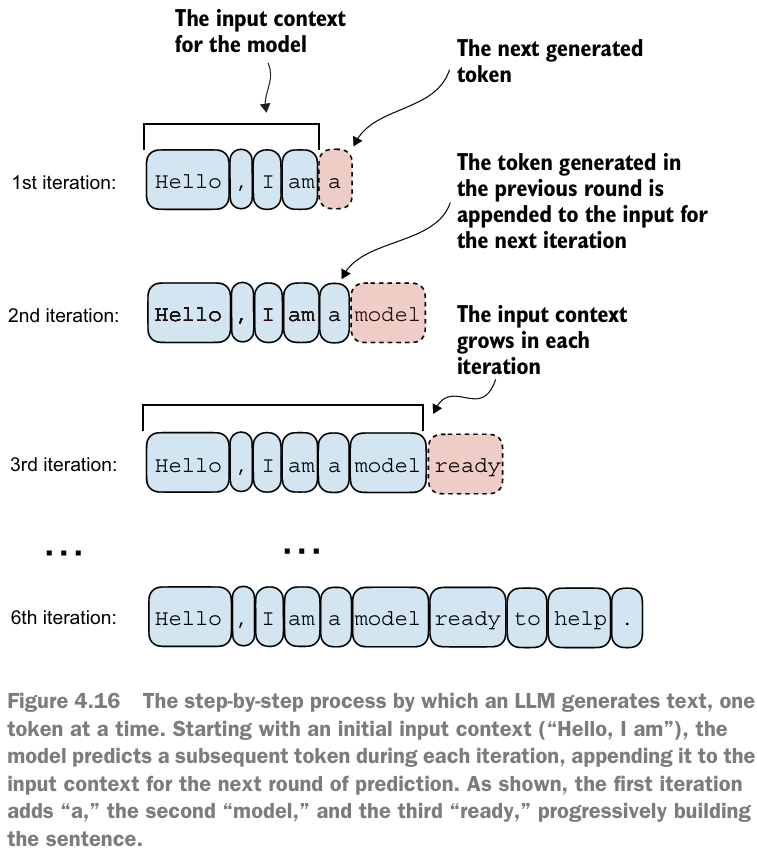

O processo de geração do próximo token detalhado na figura 4.17 ilustra uma única etapa em que o modelo GPT gera o próximo token, considerando sua entrada. Em cada etapa, o modelo gera uma matriz com vetores que representam os próximos tokens em potencial. O vetor correspondente ao próximo token é extraído e convertido em uma distribuição de probabilidade por meio da função `softmax`. Dentro do vetor que contém as pontuações de probabilidade resultantes, o índice do maior valor é localizado, o que se traduz no ID do token. Esse ID do token é então decodificado novamente em texto, produzindo o próximo token na sequência. Finalmente, esse token é anexado às entradas anteriores, formando uma nova sequência de entrada para a iteração subsequente. Esse processo passo a passo permite que o modelo gere texto sequencialmente, construindo frases e sentenças coerentes a partir do contexto de entrada inicial.

Na prática, repetimos esse processo em várias iterações, como mostrado na figura 4.16, até atingirmos um número especificado pelo usuário de tokens gerados. Em código, podemos implementar o processo de geração de tokens conforme mostrado na listagem a seguir.

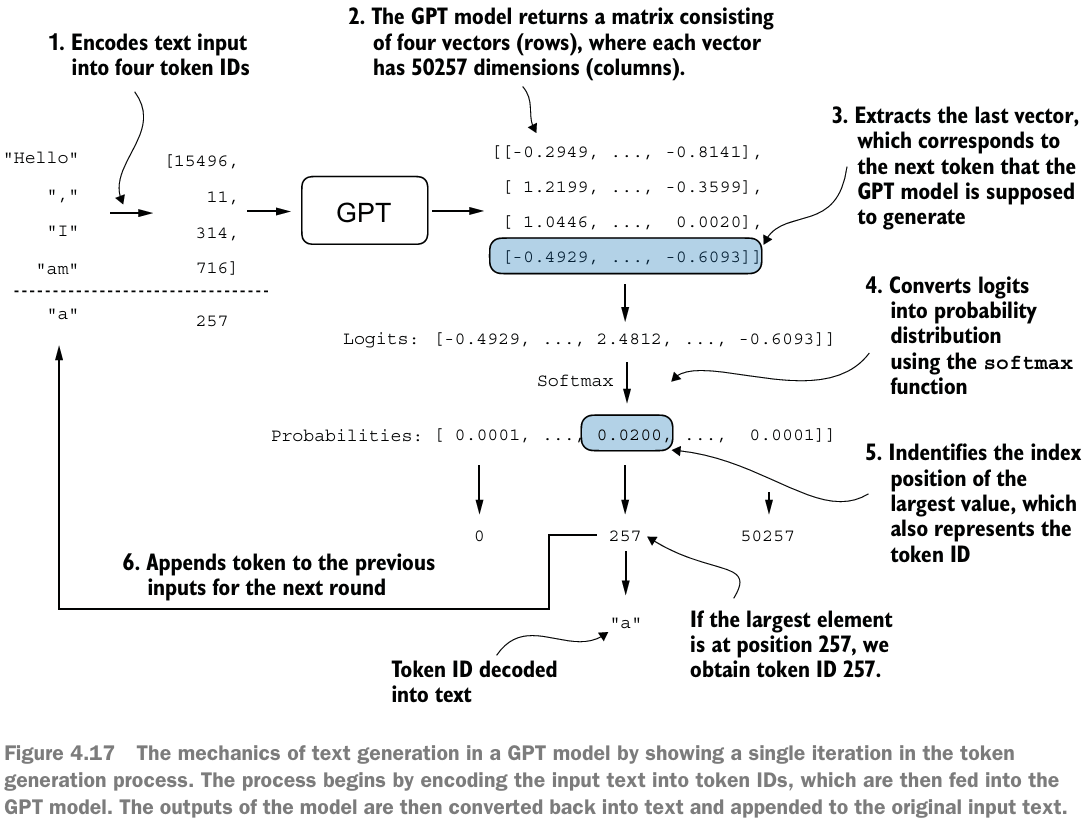

In [ ]:
def generate_text_simple(model, idx,
                         max_new_tokens, context_size):
    # Define a função generate_text_simple que gera texto token por token.
    # model: Uma instância do modelo GPT (nn.Module) a ser usado para gerar texto.
    # idx: Um tensor PyTorch contendo a sequência inicial de índices de token (o prompt).
    #      Sua forma é (batch_size, seq_len_initial).
    # max_new_tokens: O número máximo de novos tokens a serem gerados.
    # context_size: O tamanho da janela de contexto que o modelo pode processar (o número máximo de tokens de entrada).

    for _ in range(max_new_tokens):
        # Inicia um loop que irá gerar 'max_new_tokens' tokens.
        # O '_' é usado como nome da variável de loop porque o valor do contador não é usado dentro do loop.

        idx_cond = idx[:, -context_size:]
        # Seleciona os últimos 'context_size' tokens do tensor de entrada 'idx'.
        # idx[:, -context_size:]: Usa fatiamento de tensor.
        #                         O ':' na primeira dimensão significa selecionar todas as linhas (todos os exemplos no lote).
        #                         -context_size: significa começar a fatiar a partir do 'context_size' tokens antes do final.
        #                         ':' após -context_size significa ir até o final da dimensão.
        #                         Isso garante que a entrada para o modelo não exceda o tamanho máximo de contexto que ele foi treinado para lidar.
        # idx_cond: Um novo tensor contendo apenas a parte relevante (a janela de contexto) da sequência atual.
        #           Sua forma é (batch_size, context_size).

        with torch.no_grad():
            # Inicia um bloco de código onde os gradientes não serão calculados.
            # torch.no_grad(): Um gerenciador de contexto que desativa o cálculo do gradiente.
            #                  Isso é crucial durante a inferência (geração de texto) porque não precisamos calcular gradientes
            #                  para atualizar os pesos do modelo, e desativá-los economiza memória e acelera a computação.

            logits = model(idx_cond)
            # Passa o tensor de entrada condicional ('idx_cond') pelo modelo GPT.
            # model(idx_cond): Chama o método forward() do modelo com a entrada.
            # logits: O tensor de saída do modelo. Sua forma é (batch_size, seq_len_cond, vocab_size),
            #         onde seq_len_cond é o comprimento da sequência de entrada para o modelo (aqui, context_size).
            # Interpretação: O modelo processou a janela de contexto e produziu logits (pontuações brutas)
            #                para o próximo token potencial em CADA posição da sequência de entrada.

        logits = logits[:, -1, :]
        # Seleciona os logits APENAS para o último token na sequência de entrada.
        # logits[:, -1, :]: Usa fatiamento de tensor novamente.
        #                   ':' na primeira dimensão: todos os exemplos no lote.
        #                   -1 na segunda dimensão: o último índice na dimensão da sequência (a posição onde queremos prever o próximo token).
        #                   ':' na terceira dimensão: todos os logits para todos os tokens do vocabulário.
        #                   A forma resultante é (batch_size, vocab_size).
        # Interpretação: Estamos interessados apenas na previsão do modelo para o token que vem DEPOIS do último token na entrada.

        probas = torch.softmax(logits, dim=-1)
        # Converte os logits selecionados em probabilidades.
        # torch.softmax(input, dim): Aplica a função softmax ao longo de uma dimensão específica.
        # logits: O tensor de entrada para a softmax (forma: batch_size, vocab_size).
        # dim=-1: Aplica a softmax ao longo da última dimensão (a dimensão do vocabulário).
        #         Isso garante que a soma das probabilidades para todos os tokens no vocabulário seja 1 para cada exemplo no lote.
        # probas: O tensor resultante das probabilidades. Sua forma é (batch_size, vocab_size).
        # Interpretação: Agora, 'probas' contém a distribuição de probabilidade sobre todo o vocabulário para o próximo token. Cada valor indica a probabilidade de um token específico ser o próximo.

        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        # Seleciona o índice do token com a MAIOR probabilidade. Este é o token previsto pelo modelo (greedy decoding).
        # torch.argmax(input, dim, keepdim): Retorna o índice do valor máximo ao longo de uma dimensão.
        # probas: O tensor de entrada (probabilidades).
        # dim=-1: Encontra o índice máximo ao longo da última dimensão (a dimensão do vocabulário).
        # keepdim=True: Mantém a dimensão onde o argmax foi calculado, mas com tamanho 1.
        #               A forma resultante é (batch_size, 1).
        # idx_next: Um tensor contendo o índice (ID) do token previsto para ser o próximo para cada exemplo no lote.
        # Interpretação: O modelo "escolheu" o token mais provável para seguir a sequência de entrada.

        idx = torch.cat((idx, idx_next), dim=1)
        # Concatena o token previsto ('idx_next') ao tensor de sequência de entrada original ('idx').
        # torch.cat((tensor1, tensor2), dim): Concatena tensores ao longo de uma dimensão especificada.
        # (idx, idx_next): Uma tupla contendo os tensores a serem concatenados.
        #                  idx tem forma (batch_size, seq_len_atual).
        #                  idx_next tem forma (batch_size, 1).
        # dim=1: Concatena ao longo da segunda dimensão (a dimensão da sequência).
        # idx: O tensor de entrada 'idx' é atualizado para incluir o token recém-gerado.
        #      Sua forma se torna (batch_size, seq_len_atual + 1).
        # Interpretação: A sequência de entrada para a próxima iteração do loop agora inclui o token que acabou de ser gerado. Isso permite que o modelo use o token gerado como parte do contexto para prever o próximo token.

    return idx
    # Após o loop ter gerado 'max_new_tokens', a função retorna o tensor 'idx' completo,
    # que agora contém a sequência inicial (prompt) mais os tokens gerados.
    # A forma final será (batch_size, seq_len_initial + max_new_tokens).

Este código demonstra uma implementação simples de um laço generativo para um modelo de linguagem usando PyTorch. Ele itera para um número especificado de novos tokens a serem gerados, recorta o contexto atual para se ajustar ao tamanho máximo de contexto do modelo, calcula as previsões e, em seguida, seleciona o próximo token com base na previsão de maior probabilidade.

Para codificar a função `generate_text_simple`, usamos uma função `softmax` para converter os logits em uma distribuição de probabilidade a partir da qual identificamos a posição com o maior valor por meio de `torch.argmax`. A função `softmax` é monotônica, o que significa que preserva a ordem de suas entradas quando transformadas em saídas. Portanto, na prática, o passo softmax é redundante, pois a posição com a maior pontuação no tensor de saída do softmax é a mesma posição no tensor logit. Em outras palavras, poderíamos aplicar a função `torch.argmax` diretamente ao tensor logits e obter resultados idênticos. No entanto, forneço o código para a conversão para ilustrar o processo completo de transformação de logits em probabilidades, o que pode adicionar intuição adicional para que o modelo gere o próximo token mais provável, o que é conhecido como ***decodificação gananciosa (greedy decoding)***.

Ao implementarmos o código de treinamento do GPT no próximo capítulo, usaremos técnicas de amostragem adicionais para modificar as saídas do softmax de forma que o modelo nem sempre selecione o token mais provável. Isso introduz variabilidade e criatividade no texto gerado.

Este processo de gerar um ID de token por vez e adicioná-lo ao contexto usando a função `generate_text_simple` é ilustrado com mais detalhes na Figura 4.18. (O processo de geração de ID de token para cada iteração é detalhado na Figura 4.17.) Geramos os IDs de token de forma iterativa. Por exemplo, na iteração 1, o modelo recebe os tokens correspondentes a "Olá, eu sou", prevê o próximo token (com ID 257, que é "a") e o anexa à entrada. Este processo é repetido até que o modelo produza a frase completa "Olá, eu sou um modelo pronto para ajudar" após seis iterações.

Vamos agora testar a função `generate_text_simple` com o contexto "`Olá, eu sou`" como entrada do modelo. Primeiro, codificamos o contexto de entrada em IDs de token:

In [ ]:
start_context = "Hello, I am"
# Define uma string Python contendo o texto inicial (prompt) para a geração de texto.
# start_context: Variável que armazena a string "Hello, I am".

encoded = tokenizer.encode(start_context)
# Tokeniza a string 'start_context' em uma lista de IDs de token inteiros.
# tokenizer.encode(text): Este método do objeto tokenizer (que foi inicializado anteriormente para o esquema 'gpt2')
#                         converte uma string de texto em sua representação numérica, que é uma lista de inteiros, onde cada inteiro é um ID de token.
# encoded: Variável que armazena a lista resultante de IDs de token.
# Interpretação: Esta linha transforma o texto legível por humanos em uma sequência de números que o modelo GPT pode entender.

print("encoded:", encoded)
# Imprime o rótulo "encoded:" seguido pelo conteúdo da lista 'encoded'.
# Interpretação: Mostra a lista de IDs de token que correspondem ao texto "Hello, I am". Isso permite verificar a saída do tokenizador.

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
# Converte a lista de IDs de token 'encoded' em um tensor PyTorch e adiciona uma dimensão de lote.
# torch.tensor(encoded): Cria um tensor PyTorch a partir da lista 'encoded'. Se a lista tem forma (seq_len), o tensor terá forma (seq_len).
# .unsqueeze(0): Adiciona uma nova dimensão na posição 0 (o início). Isso transforma um tensor 1D de forma (seq_len) em um tensor 2D de forma (1, seq_len).
#                A dimensão adicionada representa o tamanho do lote (batch size), que é 1 neste caso, pois temos apenas uma sequência de entrada.
# encoded_tensor: Variável que armazena o tensor PyTorch 2D resultante.
# Interpretação: Esta linha prepara a entrada no formato (batch_size, seq_len) que é o esperado pelo método forward do modelo GPT.

print("encoded_tensor.shape:", encoded_tensor.shape)
# Imprime o rótulo "encoded_tensor.shape:" seguido pela forma (shape) do tensor 'encoded_tensor'.
# encoded_tensor.shape: Atributo de um tensor PyTorch que retorna uma tupla representando as dimensões do tensor.
# Interpretação: Mostra a forma do tensor de entrada final que será alimentado ao modelo. Espera-se que seja torch.Size([1, N]), onde N é o número de tokens na sequência "Hello, I am". Isso confirma que a dimensão do lote foi adicionada corretamente.

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


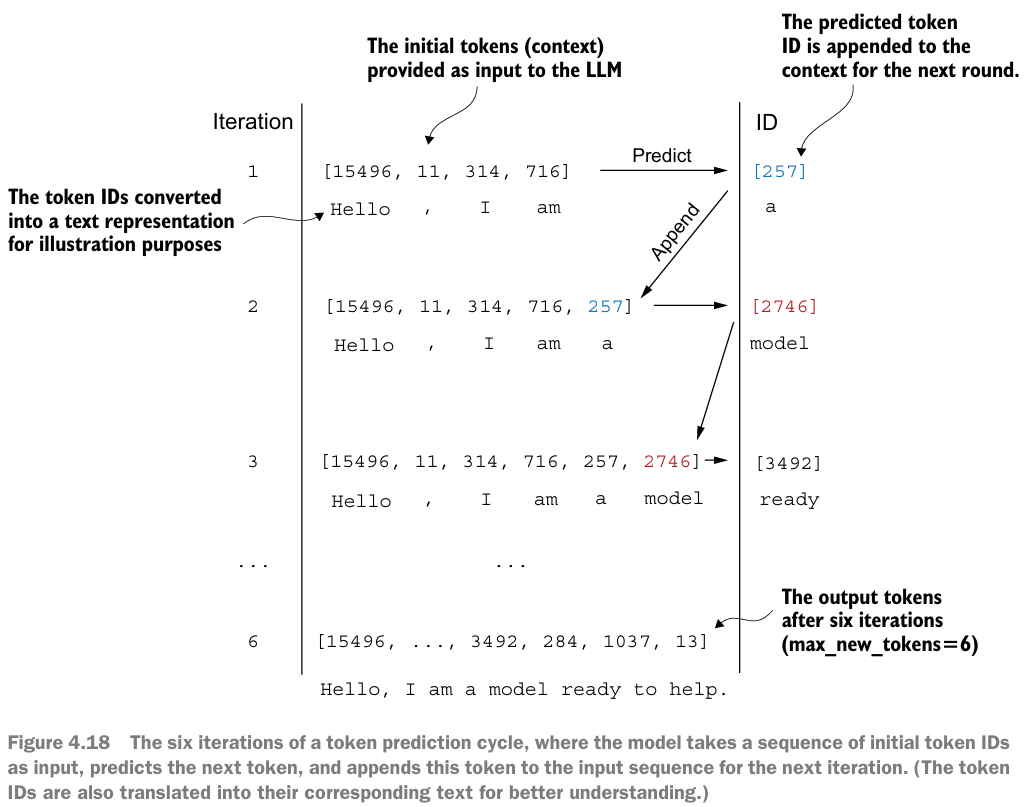

Em seguida, colocamos o modelo no modo `.eval()`. Isso desabilita componentes aleatórios como dropout, que são usados apenas durante o treinamento, e usa a função `generate_text_simple` no tensor de entrada codificado:

In [ ]:
model.eval()
# Define o modelo em modo de avaliação.
# .eval(): Um método de módulos PyTorch (nn.Module) que define o módulo e todos os seus sub-módulos para o modo de avaliação.
#          Isso afeta o comportamento de certas camadas durante a inferência (geração de texto), como camadas de Dropout e BatchNorm.
#          Em modo de avaliação, o Dropout é desativado (nenhum elemento é zerado) e a BatchNorm usa estatísticas de execução agregadas (em vez de estatísticas do mini-lote atual).
# Interpretação: Esta linha prepara o modelo para gerar texto de forma determinística, sem os efeitos aleatórios usados durante o treinamento para regularização.

out = generate_text_simple(
    # Chama a função generate_text_simple que definimos anteriormente para gerar texto.
    # O resultado da função (o tensor contendo o prompt inicial + tokens gerados) é armazenado na variável 'out'.
    model=model,
    # model: Passa a instância do modelo GPT que está em modo de avaliação.
    idx=encoded_tensor,
    # idx: Passa o tensor contendo os IDs de token do prompt inicial ("Hello, I am"), com a dimensão do lote adicionada.
    max_new_tokens=6,
    # max_new_tokens: Especifica que queremos gerar um máximo de 6 novos tokens após o prompt inicial.
    context_size=GPT_CONFIG_124M["context_length"]
    # context_size: Passa o tamanho da janela de contexto do modelo GPT (1024 para o modelo de 124M parâmetros).
    #               Isso informa à função generate_text_simple quantos tokens do contexto anterior o modelo deve considerar em cada etapa de geração.
 )
 # Interpretação: Esta seção executa o processo de geração de texto usando o modelo e o prompt fornecidos, gerando até 6 novos tokens.

print("Output:", out)
# Imprime o rótulo "Output:" seguido pelo conteúdo do tensor 'out'.
# out: O tensor PyTorch resultante da função generate_text_simple. Ele contém os IDs de token do prompt inicial concatenados com os IDs de token dos 6 tokens gerados.
# Interpretação: Mostra a sequência completa de IDs de token que foi gerada pelo modelo, incluindo o prompt.

print("Output length:", len(out[0]))
# Imprime o rótulo "Output length:" seguido pelo comprimento da primeira sequência no lote de saída.
# out[0]: Seleciona a primeira (e neste caso, única) sequência de IDs de token no tensor 'out' (remove a dimensão do lote).
# len(out[0]): Calcula o número de elementos (IDs de token) nesta sequência 1D.
# Interpretação: Mostra o número total de tokens na sequência de saída gerada. Deve ser o número de tokens no prompt inicial (3 para "Hello, I am") mais o número de novos tokens gerados (6), resultando em 9.

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


Usando o método `.decode` do tokenizador, podemos converter os IDs novamente em texto:

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
# Decodifica a sequência de IDs de token de volta para texto legível por humanos.
# tokenizer.decode(ids): Este método do objeto tokenizer (que foi inicializado anteriormente)
#                        converte uma sequência de IDs de token inteiros (uma lista ou tensor) de volta para a string de texto original.
# out: O tensor PyTorch resultante da função generate_text_simple. Sua forma é (batch_size, seq_len_total). Neste caso, (1, 9).
# .squeeze(0): Remove a dimensão de tamanho 1 na posição 0 (a dimensão do lote).
#              Isso transforma o tensor de forma (1, 9) em um tensor 1D de forma (9,).
#              O método .decode do tokenizer espera uma sequência 1D de IDs.
# .tolist(): Converte o tensor PyTorch 1D em uma lista Python padrão de inteiros.
#            O método .decode do tokenizer pode aceitar tanto tensores quanto listas, mas converter para lista é uma prática comum.
# decoded_text: Variável que armazena a string de texto resultante da decodificação.
# Interpretação: Esta linha pega a sequência numérica de IDs de token gerada pelo modelo e a transforma de volta em uma frase ou sentença que podemos ler e entender.

print(decoded_text)
# Imprime o conteúdo da string 'decoded_text'.
# Interpretação: Exibe o texto gerado pelo modelo na saída do notebook. Este será o prompt inicial concatenado com os 6 novos tokens gerados e decodificados.

Hello, I am Featureiman Byeswickattribute argue


Como podemos ver, o modelo gerou um jargão, que não se parece em nada com o texto coerente ` Hello, I am a model ready to help (Olá, sou um modelo pronto para ajudar)`. O que aconteceu? O motivo pelo qual o modelo não consegue produzir texto coerente é que ainda não o treinamos. Até agora, implementamos apenas a arquitetura GPT e inicializamos uma instância do modelo GPT com pesos aleatórios iniciais. O treinamento do modelo é um tópico extenso por si só, e o abordaremos no próximo capítulo.

---

$\large \textbf{Exercício 4.3 Usando parâmetros de dropout separados}$

No início deste capítulo, definimos uma configuração global `drop_rate` no dicionário `GPT_CONFIG_124M` para definir a taxa de dropout em vários locais da arquitetura `GPTModel`. Altere o código para especificar um valor de dropout separado para as várias camadas de dropout em toda a arquitetura do modelo. (Dica: há três locais distintos onde usamos camadas de descarte: a camada de incorporação, a camada de atalho e o módulo de atenção multicabeça.)

---

$\large \textbf{Resumo}$

- A normalização de camadas estabiliza o treinamento, garantindo que as saídas de cada camada tenham média e variância consistentes.

- Conexões de atalho são conexões que pulam uma ou mais camadas, alimentando a saída de uma camada diretamente para uma camada mais profunda, o que ajuda a mitigar o problema do gradiente de desaparecimento ao treinar redes neurais profundas, como LLMs.

- Blocos transformadores são um componente estrutural central dos modelos GPT, combinando módulos de atenção multicabeça mascarados com redes de feedforward totalmente conectadas que usam a função de ativação GELU.
- Modelos GPT são LLMs com muitos blocos transformadores repetidos que possuem milhões a bilhões de parâmetros.

- Modelos GPT vêm em vários tamanhos, por exemplo, 124, 345, 762 e 1.542 milhões de parâmetros, que podemos implementar com a mesma classe Python `GPTModel`.

- A capacidade de geração de texto de um LLM semelhante ao GPT envolve a decodificação de tensores de saída em texto legível por humanos, prevendo sequencialmente um token por vez com base em um determinado contexto de entrada.

- Sem treinamento, um modelo GPT gera texto incoerente, o que ressalta a importância do treinamento do modelo para a geração de texto coerente.